Liste des imports :

In [1]:
import os.path 
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from csv import reader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

# Apprentissage supervisé
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Apprentissate non supervisé
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from ipywidgets import interact, fixed
import ipywidgets as widgets
from bqplot import pyplot as bq_plt

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

# 1. Chargement des données

Méthode pour télécharger les données si elles ne sont pas déjà téléchargées.

In [2]:
def download_data(path, filename, url):
    csv_local_path = path + filename
    if not os.path.isfile(csv_local_path):
        with urlopen(url + filename + '.zip') as zip_response:
            with ZipFile(BytesIO(zip_response.read())) as zip_file:
                zip_file.extractall(path)
path = 'data/'
csv_name = 'fr.openfoodfacts.org.products.csv'
url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/'
download_data(path, csv_name, url)

In [3]:
csv_local_path = path + csv_name

## 1.1 Problèmes de lecture des données

Import des données :

In [4]:
df = pd.read_csv(csv_local_path, sep='\t', encoding='utf-8', low_memory=False)

On teste si la colonne code peut être transformé en entier.

In [5]:
irregular_rows = []
i = 0
for code in df.code:
    try:
        int(code)
    except:
        irregular_rows.extend([i, i + 1])
    i = i + 1

len(irregular_rows)

46

On détecte 23 lignes qui posent problème. Il faut maintenant pouvoir les lire.
[Le code a été revu pour enregister les indices des lignes précédentes, on trouve donc le double.]

Méthode pour lire des lignes choisies dans l'objectif de regarder les lignes qui posent problème.

In [6]:
def read_lines(csv_local_path, indices):
    with open(csv_local_path, 'r', encoding='utf-8') as csv_file:
        i = 0
        csv_reader = reader(csv_file)
        for row in csv_reader:
            if i in indices:
                print(row)
            i += 1

In [7]:
#read_lines(csv_local_path, irregular_rows)

On détecte que des saut de lignes sont effectués après la variable 'first_packaging_code_geo'. </br>
Plusieurs produits ont donc une partie de leur données sur une ligne et l'autre partie sur la ligne suivante.</br>
On peut essayer de supprimer les sauts de ligne dans le fichier source.</br>

## 1.2 Traitement du fichier source

On remplace les sauts de ligne suivi d'une tabulation par une simple tabulation.</br>
Il n'y a pas de tabulation en début de ligne donc seul les sauts de ligne mal placés vont sauter.</br>

In [8]:
clean_name = 'clean_food_data.csv'
clean_csv_local_path = path + clean_name

if not os.path.isfile(clean_csv_local_path):
    with open(csv_local_path, 'r', encoding='utf-8') as csv_file, open(clean_csv_local_path, 'w', encoding='utf-8') as clean_file:
        df = csv_file.read()
        clean_file.write(df.replace('\n\t', '\t'))

In [9]:
column_names = pd.read_csv(clean_csv_local_path, sep='\t', encoding='utf-8', nrows=0).columns.values

## 1.3 Préparation du type de colonnes

In [10]:
columns_dtype = {}
for column in column_names:
    if column.endswith('_100g'):
        columns_dtype[column] = 'float'
    elif column.endswith(('_n', '_t')):
        columns_dtype[column] = 'int64'
    else:
        columns_dtype[column] = 'str'

Certaines colonnes de nombres entiers posent problème dans la lecture des NaN. On enlève leur dtype et on le traitera une fois les NaN supprimées.

In [11]:
int_columns = {'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'}

del columns_dtype['additives_n']
del columns_dtype['ingredients_from_palm_oil_n']
del columns_dtype['ingredients_that_may_be_from_palm_oil_n']

In [12]:
df = pd.read_csv(clean_csv_local_path, sep='\t', encoding='utf-8', dtype=columns_dtype)

In [13]:
df.shape

(320749, 162)

In [14]:
df.dtypes.value_counts()

float64    102
object      58
int64        2
dtype: int64

In [15]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Exploration

On renomme plusieurs colonnes pour avoir plus de possibilité avec Python ou pour simplifier leur écriture.

In [16]:
new_names = {
    'saturated-fat_100g': 'saturated_fat_100g',
    'fruits-vegetables-nuts_100g': 'fruits_vegetables_nuts_100g',
    'monounsaturated-fat_100g': 'monounsaturated_fat_100g',
    'polyunsaturated-fat_100g': 'polyunsaturated_fat_100g',
    'trans-fat_100g' : 'trans_fat_100g',
    'vitamin-a_100g' : 'vitamin_a_100g',
    'vitamin-d_100g' : 'vitamin_d_100g',
    'vitamin-c_100g' : 'vitamin_c_100g',
    'vitamin-b1_100g' : 'vitamin_b1_100g',
    'vitamin-b2_100g' : 'vitamin_b2_100g',
    'vitamin-pp_100g' : 'vitamin_pp_100g',
    'vitamin-b6_100g' : 'vitamin_b6_100g',
    'vitamin-b9_100g' : 'vitamin_b9_100g',
    'vitamin-b12_100g' : 'vitamin_b12_100g',
    'nutrition-score-fr_100g': 'nutrition_score_fr_100g',
    'nutrition-score-uk_100g': 'nutrition_score_uk_100g',
    'ingredients_from_palm_oil_n': 'palm_oil_n',
    'ingredients_that_may_be_from_palm_oil_n': 'may_be_palm_oil_n',
    }
df.rename(columns=new_names, inplace=True)

## 2.0. Quelques Méthodes

On définit des méthodes pour 
1. Calculer le pourcentage de NaN,
2. Supprimer les colonnes trop remplies de NaN selon une limite que l'on peut ajuster,
3. Présenter la répartition des valeurs prises pour chaque variable qualitative spécifiée.

In [17]:
def evaluate_nan_percentage(serie):
    return serie.isna().sum()/serie.size

In [18]:
def describe_qualitative_columns(dataframe, columns, top=10, dropna=False):
    print(35 * '-'+ 'Pourcentage de NaN' + 35 * '-')
    print(dataframe[columns].isna().sum() / dataframe.shape[0])
    print(30 * '-'+ 'Compte des valeurs par variable' + 30 * '-')
    for column in columns:
        print((50 - len(column)) * '-'+ column + (50 - len(column)) * '-')
        if len(dataframe[column].value_counts(dropna=dropna)) > top:
            print(dataframe[column].value_counts(dropna=dropna)[:top])
        else:
            print(dataframe[column].value_counts(dropna=dropna))


**Méthode pour éliminer les colonnes vides**

In [19]:
def drop_nan_columns(dataframe, nan_percentage_limit, exceptions=[]):
    """
    Determine which columns has too many NaN values.
    Then it drop the given columns from the dataframe.
    """
    dropped_columns = []
    for column in dataframe.columns:
        if column not in exceptions:
            nan_percentage = evaluate_nan_percentage(dataframe[column])
            if nan_percentage > nan_percentage_limit:
                dropped_columns.append(column)
    return dataframe.drop(columns=dropped_columns)

**Méthode pour connaître les indices des NaN**

In [20]:
def nan_indices(serie):
    return serie[serie.isna()==True].index

**Méthode pour connaître les indices des outliers**

In [21]:
def outliers_indices(serie, inf, sup):
    outliers = (serie[serie>sup].index).append(serie[serie<inf].index)
    return outliers

def outliers_indices_IQR(serie):
    q75, q25 = np.percentile(serie, [75 ,25])
    iqr = (q75 - q25) * 1.5
    max = q75 + iqr
    min = q25 - iqr
    outliers = (serie[serie>max].index).append(serie[serie<min].index)
    return outliers

**Méthode pour supprimer les NaN, outliers, zéro**

In [22]:
def clean_outliers(serie):
    serie = serie.dropna()
    serie = serie.drop(outliers_indices_IQR(serie))
    return serie

def clean_zeros(serie):
    serie = serie.dropna()
    serie = serie.drop(serie[serie==0].index)
    serie = serie.drop(outliers_indices_IQR(serie))
    return serie

def clean_na_outliersIQR(df, columns=None):
    if columns:
        df = df.dropna(subset=columns)
        for column in columns:
            df = df.drop(outliers_indices_IQR(df[column]))
    else:
        df = df.dropna()
        df = df.drop(outliers_indices_IQR(df))
    return df

def clean_na_outliersIQR_zeros(df, columns=None):
    if columns:
        df = df.dropna(subset=columns)
        for column in columns:
            df = df.drop(df[df[column]==0].index)
            df = df.drop(outliers_indices_IQR(df[column]))
    else:
        df = df.dropna()
        df = df.drop(df[df==0].index)
        df = df.drop(outliers_indices_IQR(df))
    return df

**Méthode pour heatmap avec compte de NaN croissant**

In [23]:
def heatmap_nan_sorted(df, columns):
    sorted_columns = df[columns].isna().sum().sort_values().index
    sns.heatmap(df[sorted_columns].isna())

## 2.1 Détection des doublons

Pour effectuer des modfications sur les données mais conserver la base initiale, on réalise une copie.

Avant de traiter des doublons sur la composition, il peut être intéressant de conserver un copie des données.

In [24]:
work_df = df.copy()

In [25]:
start_df = work_df.copy()

### 2.1.1. Selon la colonne code

In [26]:
work_df.duplicated('code').sum()

0

On ne détecte pas de doublon selon la colonne 'code'. On peut la définir comme index.

In [27]:
work_df.set_index('code')
print('')

### 2.1.2. Selon le nom du produit

In [28]:
work_df[work_df.duplicated('product_name')].index

Int64Index([   152,    183,    187,    199,    206,    223,    227,    233,
               260,    262,
            ...
            320724, 320725, 320729, 320730, 320731, 320732, 320734, 320737,
            320743, 320748],
           dtype='int64', length=99405)

In [29]:
len(work_df[work_df.duplicated('product_name')].index) * 100 / work_df.shape[0]

30.991522966556403

On remarque que près d'un tiers des données sont des duplicats d'autres produits du même nom.  
On peut imaginer des produits de même noms mais légèrement différents.

### 2.1.3. Selon la composition et le pays de vente

In [30]:
work_df.columns[34:].insert(loc=0, item='countries_fr')

Index(['countries_fr', 'ingredients_text', 'allergens', 'allergens_fr',
       'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments',
       'additives_n',
       ...
       'ph_100g', 'fruits_vegetables_nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition_score_fr_100g',
       'nutrition_score_uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=129)

In [31]:
work_df[work_df.duplicated(work_df.columns[34:])].index
len(work_df[work_df.duplicated(work_df.columns[34:])].index) * 100 / work_df.shape[0]

13.297313475646066

Ces doublons représentent 13% des données. Le pourcentage n'est pas négligeable.  

### 2.1.4. Selon le nom du produit et colonnes pertinentes

In [32]:
duplicate_base = [
       'product_name',
       'labels_fr', 'countries_fr', 'allergens', 'additives_n',
       'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated_fat_100g',
       'trans_fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'vitamin_a_100g', 'vitamin_c_100g', 'calcium_100g', 'iron_100g',
       ]

In [33]:
work_df[work_df.duplicated(duplicate_base)]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits_vegetables_nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,glycemic-index_100g,water-hardness_100g
152,0000000045599,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489050423,2017-03-09T09:07:03Z,1489050423,2017-03-09T09:07:03Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
183,0000007020254,http://world-fr.openfoodfacts.org/produit/0000...,teolemon,1420150193,2015-01-01T22:09:53Z,1420210373,2015-01-02T14:52:53Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,0000050157846,http://world-fr.openfoodfacts.org/produit/0000...,teolemon,1482847730,2016-12-27T14:08:50Z,1482847738,2016-12-27T14:08:58Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280,00003001,http://world-fr.openfoodfacts.org/produit/0000...,date-limite-app,1464209294,2016-05-25T20:48:14Z,1464209295,2016-05-25T20:48:15Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,00006666,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1456141429,2016-02-22T11:43:49Z,1456141432,2016-02-22T11:43:52Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320729,98709870987,http://world-fr.openfoodfacts.org/produit/9870...,openfoodfacts-contributors,1472254210,2016-08-26T23:30:10Z,1474729393,2016-09-24T15:03:13Z,NaN,NaN,33cl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320731,9876567898765,http://world-fr.openfoodfacts.org/produit/9876...,openfoodfacts-contributors,1472253428,2016-08-26T23:17:08Z,1472253428,2016-08-26T23:17:08Z,nf test,NaN,100g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320732,988639,http://world-fr.openfoodfacts.org/produit/988639,tacite-mass-editor,1490554698,2017-03-26T18:58:18Z,1490554698,2017-03-26T18:58:18Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320737,99044169,http://world-fr.openfoodfacts.org/produit/9904...,date-limite-app,1421873458,2015-01-21T20:50:58Z,1460898286,2016-04-17T13:04:46Z,Poireaux,NaN,1 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
len(work_df[work_df.duplicated(duplicate_base)].index) * 100 / work_df.shape[0]

9.853187383281007

Ces doublons représentent 10% des données. Le pourcentage n'est pas négligeable.  
Pour que ces doublons ne fausse pas certaines analyse, on choisit de supprimer ces doublons sachant que l'on conserve un jeu de données de 278 000 individus.

In [35]:
##################################################################
work_df.drop_duplicates(subset=duplicate_base, inplace=True)
work_df.shape
##################################################################

(289145, 162)

In [36]:
work_df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits_vegetables_nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition_score_fr_100g',
       'nutrition_score_uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

1. On cible tout d'abord les colonnes assez remplies.
2. On trie ensemble les variables redondantes pour selectionner ou recomposer de nouvelles.
3. Enfin on passe en revue les colonnes par ordre de pertinence.  

## 2.2 Ciblage

In [37]:
work_df = drop_nan_columns(work_df, 0.90)
work_df.shape

(289145, 62)

Il reste 62 colonnes pour 289 145 individus.

## 2.3 Tri des variables

In [38]:
work_df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr',
       'manufacturing_places', 'manufacturing_places_tags', 'labels',
       'labels_tags', 'labels_fr', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'palm_oil_n', 'may_be_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url',
       'energy_100g', 'fat_100g', 'saturated_fat_100g', 'trans_fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'v

On identifie beaucoup de colonnes de composition qui terminent par _100g.  
On différencie la colonne energy et les colonnes nutrition-score de la majorité des colonnes qui sont en g ou ml pour 100g, 100ml.  
Les éléments nutritionnels représentent beaucoup de colonnes, les données sont importantes pour notre objectif autour de la santé.  

On a 
- des colonnes de score nutrition
- des colonnes sur la composition des aliments :
    - dont le elements_columns déjà créés
    - dont les additives
    - dont les allergènes
    - dont les ingrédient avec de l'huile de palme
    - la liste des ingrédients

- des colonnes identifiant le produit,
- des colonnes propres à la fiche d'information,
- des colonnes autour des quantités,
- des colonnes sur l'emballage,
- des colonnes sur la classification,
- des colonnes sur la localisation (vente/production)



In [39]:
non_relevant_columns = set()
start_work_df = work_df.copy()

In [40]:
energy_columns = set()
nutrition_score_columns = set()
elements_columns = set()

for column in work_df.columns:
    if 'energy' in column:
        energy_columns.add(column)
    elif 'nutrition_score' in column:
        nutrition_score_columns.add(column)
    elif column.endswith('_100g'):
        elements_columns.add(column)

### 2.3.1 Identifiants

In [41]:
id_columns = {'code', 'generic_name', 'product_name'}

Ces colonnes renseigne sur le produit. On ne conserve pas ces données.

In [42]:
non_relevant_columns.update(id_columns)

### 2.3.2. Fiche produit

In [43]:
sheet_columns = {'url', 'creator', 'created_t', 'created_datetime',
                 'last_modified_t', 'last_modified_datetime',
                 'image_url', 'image_small_url',
                 'states', 'states_tags', 'states_fr'}

Ces colonnes nous informe sur la fiche produit, elle ne nous sont donc pas utiles.

In [44]:
non_relevant_columns.update(sheet_columns)

### 2.3.3. Quantités

In [45]:
quantity_columns = {'quantity','serving_size'}

In [46]:
describe_qualitative_columns(start_work_df, quantity_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
serving_size    0.320130
quantity        0.647564
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
--------------------------------------serving_size--------------------------------------
NaN                 92564
240 ml (8 fl oz)     5021
28 g (1 oz)          4833
28 g (1 ONZ)         3502
30 g (2 Tbsp)        2688
30 g                 2565
15 ml (1 Tbsp)       2328
30 g (0.25 cup)      1936
240 ml (1 cup)       1638
100 g                1637
Name: serving_size, dtype: int64
------------------------------------------quantity------------------------------------------
NaN      187240
500 g      4507
200 g      3993
250 g      3785
100 g      2983
400 g      2466
300 g      2424
150 g      2264
1 l        1617
1 kg       1524
Name: quantity, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


Les deux données sont proches, l'une est le poids total, l'autre la part servie.  
Elle sont néanmoins qualitatives car l'unité n'est pas unique.  
Le traitement pour les rendre quantitatives semble complexe:
 - il y a deux grandeurs selon s'il s'agit d'un liquide ou non (Volume ou masse).
 - dans une même grandeur, pas d'unité unique
 - la donnée peut contenir le détail des masses des sous emballage.  
 
La donnée 'serving_size' est plutôt bien renseignée (32% de NaN).


In [47]:
non_relevant_columns.update(quantity_columns)

### 2.3.4. Emballages

In [48]:
packaging_columns = {'packaging', 'packaging_tags'}  # 'emb_codes', 'emb_codes_tags'

In [49]:
describe_qualitative_columns(start_work_df, packaging_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
packaging_tags    0.732861
packaging         0.732864
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
------------------------------------packaging_tags------------------------------------
NaN                    211903
sachet,plastique         3896
carton                   2896
plastique                2745
barquette,plastique      2048
bouteille,verre          1593
conserve                 1585
bouteille,plastique      1494
bocal,verre              1457
kunststoff               1302
Name: packaging_tags, dtype: int64
-----------------------------------------packaging-----------------------------------------
NaN                    211904
Carton                   2130
Sachet,Plastique         2107
Plastique                1872
Kunststoff               1299
Bouteille,Verre          1282
Conserve                 1230
sachet,plastique         1

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


Il s'agit de quatres données qualitatives.  
On choisit de se séparer de ces variables puisque :
- Les données sont mal renseignées de 72% à 89% de NaN, très morcelées et pas homogènes.  
- De plus les unités ne sont pas homogènes, même pour une même grandeur (Masse ou volume).  
- Le rapport avec la santé n'apparaît pas évident.



In [50]:
non_relevant_columns.update(packaging_columns)

### 2.3.5. Catégories

On trouve un certain nombre de variable qui cherche à catégoriser les produits.  
On retrouve des groupes PNNS du Programme National Nutrition Santé.

In [51]:
category_columns = {
                     'main_category', 'main_category_fr',
                     'categories', 'categories_tags', 'categories_fr',
                     'pnns_groups_1','pnns_groups_2'
}

In [52]:
describe_qualitative_columns(start_work_df, category_columns)

-----------------------------------Pourcentage de NaN-----------------------------------


C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


categories_fr       0.715783
main_category       0.715783
pnns_groups_1       0.696675
pnns_groups_2       0.687098
categories_tags     0.715783
main_category_fr    0.715783
categories          0.715783
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
-------------------------------------categories_fr-------------------------------------
NaN                                                                                                                                                                 206965
Snacks sucrés,Biscuits et gâteaux,Biscuits                                                                                                                             798
Snacks sucrés,Chocolats,Chocolats noirs                                                                                                                                603
Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréa

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2598085744.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_columns = df[columns].isna().sum().sort_values().index


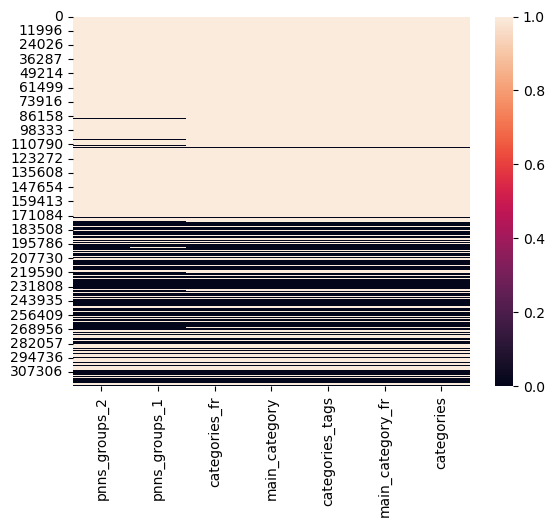

In [53]:
heatmap_nan_sorted(start_work_df, category_columns)

Les variables sont redondantes et on voit distingue deux groupes où les NaN correspondent parfaitement :
 - les groupes PNNS 1 et 2
 - les variables avec le mot category
 
Elles sont globalement, mal renseignées repectivement autour de 69% et 71% de NaN.  

On choisit de recomposer une variable category avec les données des deux groupes de variables :
 - d'un côté pnns_groups_1
 - de l'autre la variable main_category

In [54]:
work_df['category'] = work_df.pnns_groups_1.replace({
    'fruits-and-vegetables': 'Fruits and vegetables',
    'sugary-snacks': 'Sugary snacks',
    'cereals-and-potatoes': 'Cereals and potatoes',
    'salty-snacks': 'Salty snacks',
})

On utilise les groupes PNNS comme repère de catégorie.

In [55]:
work_df.category = work_df.category.fillna(work_df.pnns_groups_2)

work_df.category = work_df.category.fillna(work_df.main_category_fr)
match = {'Alcoholic beverages': 'Beverages',
         'Tripe dishes': 'Fish Meat Eggs',
         'unknown': pd.NA,
}
work_df.category = work_df.category.replace(match)

In [56]:
work_df.category.value_counts(dropna=False, normalize=True)

NaN                        0.687098
<NA>                       0.070079
Sugary snacks              0.043681
Beverages                  0.039527
Milk and dairy products    0.030182
Cereals and potatoes       0.028906
Fish Meat Eggs             0.027498
Composite foods            0.023148
Fruits and vegetables      0.022847
Fat and sauces             0.017455
Salty snacks               0.009580
Name: category, dtype: float64

##### Bilan
On conserve 74% de NaN, plus qu'indiqué plus haut mais le chiffre ne tenait pas compte de la catégorie 'unknown'.

In [57]:
non_relevant_columns.update(category_columns)

### 2.3.6. Marque

In [58]:
brands_columns = {'stores', 'brands', 'brands_tags'}

In [59]:
describe_qualitative_columns(start_work_df, brands_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
brands         0.052171
stores         0.824534
brands_tags    0.052199
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
--------------------------------------------brands--------------------------------------------
NaN             15085
Carrefour        2922
Auchan           2249
U                2016
Meijer           1650
Leader Price     1619
Kroger           1569
Casino           1535
Roundy's         1183
Ahold            1172
Name: brands, dtype: int64
--------------------------------------------stores--------------------------------------------
NaN            238410
Carrefour        6357
Auchan           2827
Leclerc          2786
Cora             2211
Intermarché      2178
Lidl             1711
Franprix         1635
Aldi             1389
Super U          1350
Name: stores, dtype: int64
---------------------------------------brands_ta

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


Les variables 'stores' nous permet de connaître l'enseigne. On peut donc l'utiliser pour alimenter les NaN de 'brands'.

In [60]:
work_df['brands'].fillna(work_df['stores'], inplace=True)

In [61]:
work_df['brands'].fillna("Aucun", inplace=True)

In [62]:
non_relevant_columns.update({'stores', 'brands_tags'})

### 2.3.7. Lieu

In [63]:
location_columns = {
                     'countries', 'countries_tags', 'countries_fr',
                     'manufacturing_places', 'manufacturing_places_tags',
                     'purchase_places'
}

In [64]:
describe_qualitative_columns(start_work_df, location_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
countries_tags               0.000730
manufacturing_places_tags    0.875592
purchase_places              0.803334
countries                    0.000730
manufacturing_places         0.875571
countries_fr                 0.000730
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
------------------------------------countries_tags------------------------------------
en:united-states            158286
en:france                    85381
en:switzerland               13551
en:germany                    6882
en:spain                      4365
en:united-kingdom             3531
en:belgium                    1921
en:australia                  1596
en:russia                     1243
en:france,en:switzerland      1219
Name: countries_tags, dtype: int64
-------------------------manufacturing_places_tags-------------------------
NaN               253173
fra

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


In [65]:
start_work_df[location_columns].isna().sum().sort_values().index

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2935832316.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_work_df[location_columns].isna().sum().sort_values().index


Index(['countries_tags', 'countries', 'countries_fr', 'purchase_places',
       'manufacturing_places', 'manufacturing_places_tags'],
      dtype='object')

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2598085744.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_columns = df[columns].isna().sum().sort_values().index


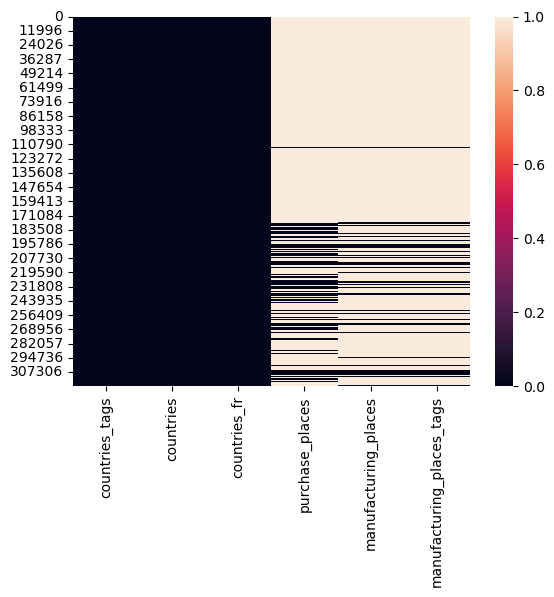

In [66]:
heatmap_nan_sorted(start_work_df, location_columns)

Les variables 'manufactoring_places', 'purchase_places' sont à la fois trop détaillées et remplies de NaN.</br>
Les variables de pays on l'avantage d'être bien renseignée sans NaN, mais redondantes, il faut en conserver une :</br>
'countries_fr' semble la plus appropriée.

In [67]:
non_relevant_columns.update({'countries',
                             'countries_tags',
                             'manufacturing_places',
                             'manufacturing_places_tags',
                             'purchase_places'})

### 2.3.8. Labels

In [68]:
labels_columns = {'labels', 'labels_tags', 'labels_fr'}

In [69]:
describe_qualitative_columns(start_work_df,labels_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
labels_fr      0.840302
labels_tags    0.840302
labels         0.840596
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
-----------------------------------------labels_fr-----------------------------------------
NaN                                                     242969
Bio,Bio européen,AB Agriculture Biologique                5282
Point Vert                                                2429
Végétarien,Végétalien                                     1553
Point Vert,Eco-emballages                                  828
Bio,Bio européen,FR-BIO-01,AB Agriculture Biologique       827
Sans gluten                                                473
Labels de distributeurs,Sélection Intermarché              451
AOP                                                        430
Sans colorants,Sans conservateurs                          416
Name: labe

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2598085744.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_columns = df[columns].isna().sum().sort_values().index


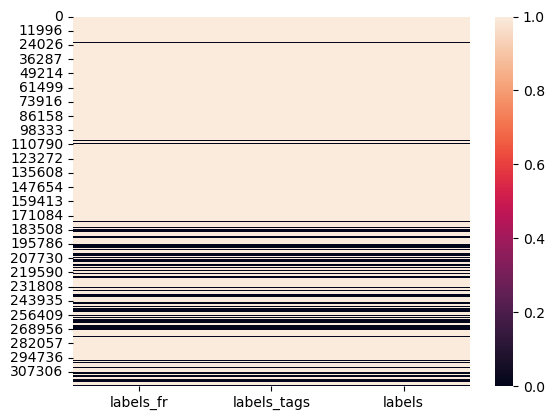

In [70]:
heatmap_nan_sorted(start_work_df, labels_columns)

On compte 85% de NaN qui coïncident pour les différentes variables.  
Le fait d'avoir un label est assez rare, donc on peut supposer que l'absence signifie qu'il n'y a pas de label.  
On choisit de conserver 'label_fr'.  

In [71]:
non_relevant_columns.update({'labels', 'labels_tags'})

In [72]:
work_df.labels_fr = work_df.labels_fr.notnull()

### 2.3.9. Eléments nutritionnels

In [73]:
start_work_df[elements_columns].describe()

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\1916961087.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_work_df[elements_columns].describe()


,cholesterol_100g,vitamin_a_100g,iron_100g,saturated_fat_100g,sugars_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,trans_fat_100g,vitamin_c_100g,fiber_100g,salt_100g,calcium_100g
count,132793.000000,127195.000000,130068.000000,217484.000000,231921.000000,245033.000000,240625.000000,229058.000000,228757.000000,131833.000000,130472.000000,190132.000000,240672.000000,130768.000000
mean,0.020216,0.000415,0.003792,5.114920,15.974153,7.124110,0.796934,12.545421,32.307822,0.077382,0.024711,2.852146,2.023824,0.126531
std,0.372786,0.076204,0.222807,7.966324,22.202755,8.384316,52.028932,16.894383,29.614936,1.600755,2.323803,13.168812,132.140590,3.445634
min,0.000000,-0.000340,-0.000260,0.000000,-17.860000,-800.000000,0.000000,0.000000,0.000000,-3.570000,-0.002100,-6.700000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.370000,0.800000,0.027559,0.000000,6.250000,0.000000,0.000000,0.000000,0.070000,0.000000
50%,0.000000,0.000000,0.001030,1.800000,5.880000,4.900000,0.233000,5.300000,21.430000,0.000000,0.000000,1.500000,0.591820,0.036000
75%,0.021000,0.000107,0.002400,7.140000,24.100000,10.000000,0.544000,20.000000,58.400000,0.000000,0.003800,3.600000,1.380000,0.106000
max,95.238000,26.700000,50.000000,550.000000,3520.000000,430.000000,25320.000000,714.290000,2916.670000,369.000000,716.981100,5380.000000,64312.800000,694.737000


### 2.3.10. Score de nutrition

Les variables de score de nutrition informent directement sur la qualité de l'aliment pour la santé.   
La variable cible pour notre étude sera donc une variable nutrition score. 

In [74]:
nutriscore_columns = {'nutrition_score_fr_100g',
                      'nutrition_score_uk_100g',
                      'nutrition_grade_fr',}

In [75]:
describe_qualitative_columns(start_work_df, nutriscore_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
nutrition_score_fr_100g    0.272825
nutrition_score_uk_100g    0.272825
nutrition_grade_fr         0.272825
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
---------------------------nutrition_score_fr_100g---------------------------
 NaN     78886
 0.0     11926
 1.0     10726
 14.0    10708
 2.0     10077
 13.0     8483
 11.0     8364
 12.0     8277
-1.0      8228
 3.0      7589
 15.0     7253
 10.0     6689
Name: nutrition_score_fr_100g, dtype: int64
---------------------------nutrition_score_uk_100g---------------------------
 NaN     78886
 0.0     12742
 1.0     11383
 2.0     10525
 14.0    10160
-1.0      8251
 13.0     8081
 12.0     7855
 11.0     7822
 3.0      7356
 20.0     6972
 15.0     6650
 10.0     6232
Name: nutrition_score_uk_100g, dtype: int64
--------------------------------nutrition_grade_fr---------------------------

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


On compte beaucoup de NaN, de l'ordre de 25%. Cependant la variable est centrale dans notre étude.  
La variable nutrition_grade_fr semble la plus appropriée pour réaliser une étude (avec moins de catégorie, et plus parlante)

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2598085744.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_columns = df[columns].isna().sum().sort_values().index


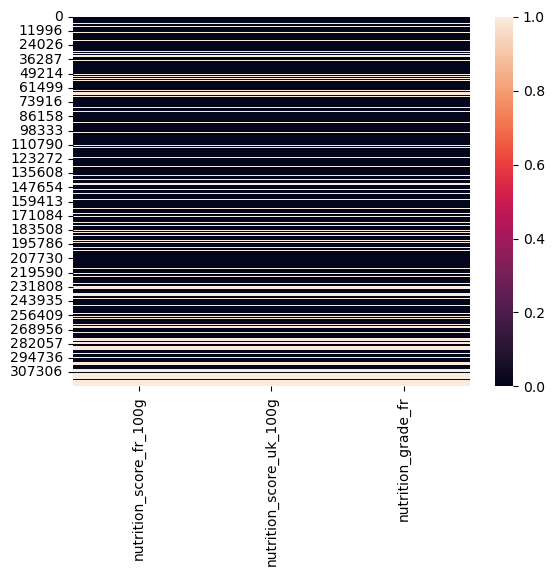

In [76]:
heatmap_nan_sorted(start_work_df, nutriscore_columns)

Les NaN coïncident, il n'y pas d'informations à reprendre des autres colonnes de score de nutrition.

In [77]:
non_relevant_columns.update({'nutrition_score_fr_100g', 'nutrition_score_uk_100g'})

### 2.3.11. Autres

Additifs - Huile de palme - Liste des ingrédients

In [78]:
additives_columns = {'additives_n', 'additives', 'additives_tags', 'additives_fr'}
palm_oil_columns = {
       'palm_oil_n',
       'may_be_palm_oil_n', 
}


##### Les additifs

In [79]:
describe_qualitative_columns(start_work_df, additives_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
additives_n       0.193038
additives_fr      0.493071
additives         0.193152
additives_tags    0.493071
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
---------------------------------------additives_n---------------------------------------
0.0     86753
NaN     55816
1.0     43755
2.0     34576
3.0     22495
4.0     14532
5.0     10349
6.0      6887
7.0      4508
8.0      3214
9.0      2096
10.0     1292
Name: additives_n, dtype: int64
--------------------------------------additives_fr--------------------------------------
NaN                                              142569
E322 - Lécithines                                  7963
E330 - Acide citrique                              7205
E375 - Acide nicotinique,E101 - Riboflavine        7117
E300 - Acide ascorbique                            2859
E415 - Gomme xanthane                

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 55849
 [ almonds -> en:almonds  ]                                                                                                                                                                                                                                                                                                                                                                                                                                                           213
 [ semoule-de-ble-dur-de-qualite-superieure -> fr:se

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2598085744.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_columns = df[columns].isna().sum().sort_values().index


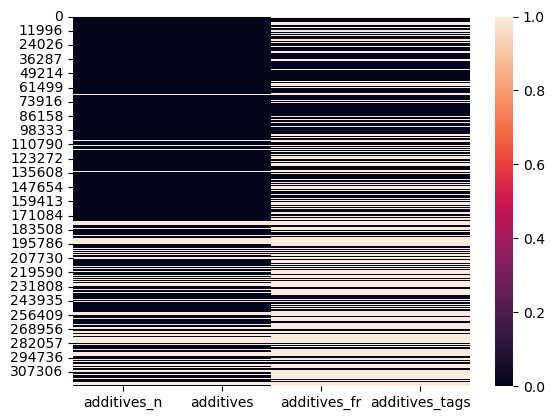

In [80]:
heatmap_nan_sorted(work_df, additives_columns)

Le nombre d'additifs est la colonne la plus renseignée.

In [81]:
non_relevant_columns.update({'additives', 'additives_tags', 'additives_fr'})

Même si on pourrait compter les additifs dans les autres colonnes à l'aide de liste, les NaN du nombres d'additifs sont également NaN pour l'ensemble des 3 autres colonnes :

In [82]:
work_df[work_df['additives_n'].isnull()].index.isin(work_df[work_df['additives_tags'].notnull()].index).sum()

0

In [83]:
work_df[work_df['additives_n'].isnull()].index.isin(work_df[work_df['additives_fr'].notnull()].index).sum()

0

In [84]:
work_df[work_df['additives_n'].isnull()].index.isin(work_df[work_df['additives'].notnull()].index).sum()

0

##### L'huile de palme

In [85]:
describe_qualitative_columns(start_work_df, palm_oil_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
may_be_palm_oil_n    0.193038
palm_oil_n           0.193038
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
---------------------------------may_be_palm_oil_n---------------------------------
0.0    221981
NaN     55816
1.0      9700
2.0      1311
3.0       285
4.0        45
5.0         6
6.0         1
Name: may_be_palm_oil_n, dtype: int64
----------------------------------------palm_oil_n----------------------------------------
0.0    228516
NaN     55816
1.0      4754
2.0        59
Name: palm_oil_n, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_8092\553466848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(dataframe[columns].isna().sum() / dataframe.shape[0])


C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2598085744.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_columns = df[columns].isna().sum().sort_values().index


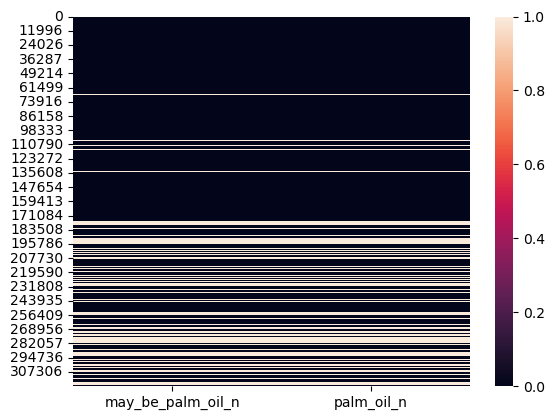

In [86]:
heatmap_nan_sorted(work_df, palm_oil_columns)

On peut regrouper les deux variables en une variable booléenne qui dira si l'aliment peut contenir de l'huile de palme ou non.

In [87]:
work_df['palm_oil'] = (work_df.may_be_palm_oil_n > 0) | (work_df.palm_oil_n > 0)

On remplace donc les deux colonnes par cette nouvelle colonne.

In [88]:
non_relevant_columns.update({'may_be_palm_oil_n', 'palm_oil_n'})

##### La liste des ingrédients

In [89]:
describe_qualitative_columns(start_work_df, ['ingredients_text'])

-----------------------------------Pourcentage de NaN-----------------------------------
ingredients_text    0.193038
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
----------------------------------ingredients_text----------------------------------
NaN                                                                                                                    55816
Almonds.                                                                                                                 171
Semolina (wheat), durum flour (wheat), niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid.      147
Carbonated water, natural flavor.                                                                                        135
Semoule de _blé_ dur de qualité supérieure.                                                                              110
Walnuts.                                                         

La donnée est complexe à interpréter.

In [90]:
non_relevant_columns.add('ingredients_text')

### 2.3.12. Rajout après analyse des corrélations

Les éléments sodium et sel sont très corrélés (quasi totalement).  
Avec une telle corrélation, un modèle de régression pourrait être révélateur.

Des lignes seront par la suite commentée puisque la variable ne sera plus accessible.
Si l'on souhaite les exécuter, commenter cette ligne puis décommenter les lignes souhaitées.

In [91]:
work_df[['sodium_100g','salt_100g']].corr()

,sodium_100g,salt_100g
sodium_100g,1.0,1.0
salt_100g,1.0,1.0


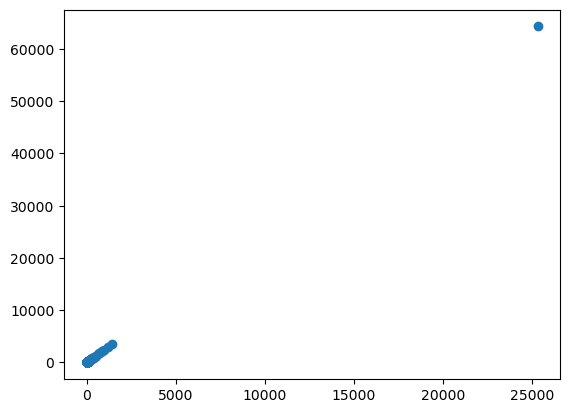

In [92]:
plt.scatter(work_df['sodium_100g'], work_df['salt_100g'])

In [93]:
work_df[work_df['sodium_100g']>20000]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,category,palm_oil
145844,0786754430200,http://world-fr.openfoodfacts.org/produit/0786...,usda-ndb-import,1489095497,2017-03-09T21:38:17Z,1489095497,2017-03-09T21:38:17Z,Prickly Syrup,NaN,NaN,...,64312.8,25320.0,NaN,NaN,NaN,NaN,23.0,23.0,NaN,False


On identifie un outlier. Un seul produit est une perte acceptable.

In [94]:
work_df = work_df.drop(work_df[work_df['sodium_100g']>20000].index)

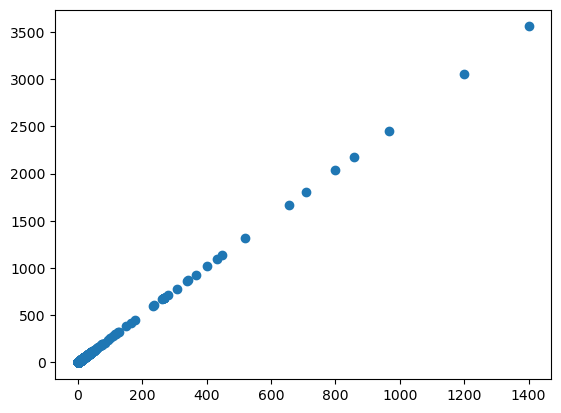

In [95]:
plt.scatter(work_df['sodium_100g'], work_df['salt_100g'])

In [96]:

model = LinearRegression()
linear_df = work_df[['sodium_100g', 'salt_100g']].dropna()
n = linear_df['sodium_100g'].shape[0]
x = linear_df['sodium_100g'].values.reshape(n,1)
y = linear_df['salt_100g'].values.reshape(n,1)
model.fit(x, y)
model.score(x, y)



0.9999999930794312

In [97]:
model.coef_

array([[2.54000451]])

In [98]:
model.intercept_

array([2.17098417e-06])

Le modèle confirme un rapport de 2.5 entre le sodium et le sel que l'on peut trouver dans diverses sources dont celle-ci des des hopitaux universitaires de Genève https://www.nephrohug.ch/2016/04/20/le-sel-le-sodium-quelle-difference/.

In [99]:
work_df[['sodium_100g','salt_100g']].isnull().sum()

sodium_100g    48520
salt_100g      48473
dtype: int64

In [100]:
work_df[work_df['salt_100g'].isnull()].index.isin(work_df[work_df['sodium_100g'].notnull()].index).sum()

0

On confirme que les NaN coïncident à l'exception de 47 NaN supplémentaires pour la donnée sodium.

In [101]:
non_relevant_columns.add('sodium_100g')
elements_columns.remove('sodium_100g')

### Bilan

In [102]:
work_df = work_df.drop(columns=non_relevant_columns)

In [103]:
work_df.columns

Index(['brands', 'labels_fr', 'countries_fr', 'additives_n',
       'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated_fat_100g',
       'trans_fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'vitamin_a_100g', 'vitamin_c_100g', 'calcium_100g', 'iron_100g',
       'category', 'palm_oil'],
      dtype='object')

In [104]:
work_df.shape

(289144, 21)

In [105]:
work_df.dtypes

brands                 object
labels_fr                bool
countries_fr           object
additives_n           float64
nutrition_grade_fr     object
energy_100g           float64
fat_100g              float64
saturated_fat_100g    float64
trans_fat_100g        float64
cholesterol_100g      float64
carbohydrates_100g    float64
sugars_100g           float64
fiber_100g            float64
proteins_100g         float64
salt_100g             float64
vitamin_a_100g        float64
vitamin_c_100g        float64
calcium_100g          float64
iron_100g             float64
category               object
palm_oil                 bool
dtype: object

In [106]:
work_df['nutrition_grade_fr'].isnull().sum()

78886

In [107]:
work_df.shape

(289144, 21)

## 2.4 Pré-Traitement

On traite les variables par ordre de pertinence pour notre étude.

### 2.4.1. Variable cible : Nutriscore

De part l'importance de la variable, on choisit de supprimer les données sans nutriscore.  
On en profite pour créer un dataframe qui ne sera pas altéré par des changements, on y supprimera des lignes ou colonnes mais les valeurs ne seront pas remplacées.

In [108]:
work_df = work_df.dropna(subset=['nutrition_grade_fr'])
clean_df = work_df.copy()

In [109]:
work_df.shape

(210258, 21)

### 2.4.2. Eléments nutritionnels

#### 1. Traitement des NaN

In [110]:
(work_df[elements_columns].isna().sum()/work_df.shape[0]).sort_values()

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\1033305747.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (work_df[elements_columns].isna().sum()/work_df.shape[0]).sort_values()


saturated_fat_100g    0.000899
sugars_100g           0.000899
proteins_100g         0.000899
salt_100g             0.000899
fat_100g              0.082874
carbohydrates_100g    0.082998
fiber_100g            0.128670
cholesterol_100g      0.396394
calcium_100g          0.404161
trans_fat_100g        0.404855
iron_100g             0.408027
vitamin_c_100g        0.415528
vitamin_a_100g        0.419594
dtype: float64

Le nombre de NaN permet de différencier :
- les éléments qui sont pratiquement toujours présents : le sucre, le sel, le sodium, les protéines, les graisses saturées.
- les élements assez fréquents : les graisses, les glucides, les fibres
- les élements plutôt rares : le cholestérol, la calcium, les acides gras trans, le fer, les vitamines A et C

##### Eléments principaux

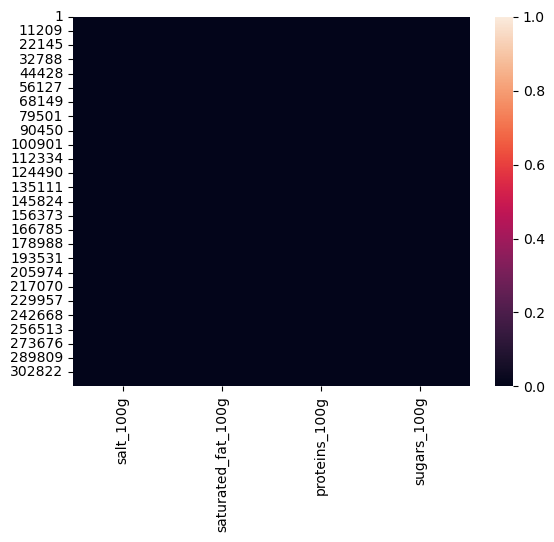

In [111]:
heatmap_nan_sorted(work_df, ['salt_100g', 'saturated_fat_100g', 'proteins_100g', 'sugars_100g'])

In [112]:
nan_element_indices = set()
for column in ['salt_100g', 'saturated_fat_100g', 'proteins_100g', 'sugars_100g']:
    nan_element_indices.update(work_df[work_df[column].isnull() == True].index)
len(nan_element_indices)

189

La heatmap ne permet pas d'identifier la correspondance des NaN.  
Ce pendant la construction du set montre que les 189 indices correspondent parfaitement entre les 5 variables.  
D'ailleurs en supprimant les NaN d'uniquement la variable sel, on verra par la suite qu'il ne reste pas de NaN dans les autres colonnes.

In [113]:
work_df = work_df.dropna(subset=['salt_100g'])
clean_df = clean_df.dropna(subset=['salt_100g'])

In [114]:
work_df.shape

(210069, 21)

##### Eléments secondaires

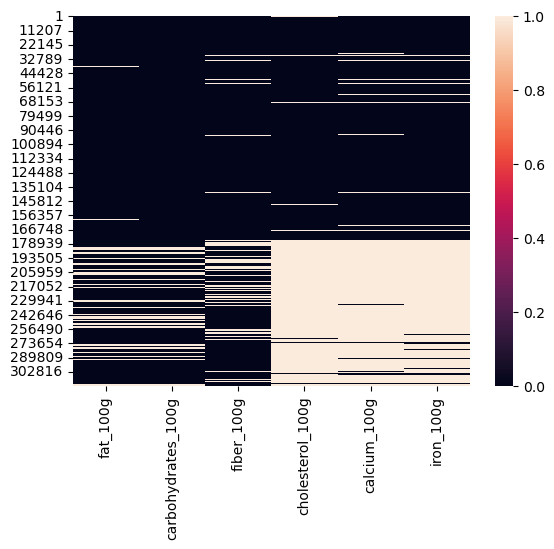

In [115]:
heatmap_nan_sorted(work_df, ['calcium_100g', 'carbohydrates_100g', 'cholesterol_100g', 'fat_100g', 'fiber_100g', 'iron_100g'])

Pour ces données plus rares, on choisit de remplir les valeurs par des valeurs nulles.

In [116]:
for column in elements_columns:
    work_df[column] = work_df[column].fillna(0)

Vérifications

In [117]:
(work_df[elements_columns].isna().sum()/work_df.shape[0]).sort_values()

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\1033305747.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (work_df[elements_columns].isna().sum()/work_df.shape[0]).sort_values()


cholesterol_100g      0.0
vitamin_a_100g        0.0
iron_100g             0.0
saturated_fat_100g    0.0
sugars_100g           0.0
proteins_100g         0.0
fat_100g              0.0
carbohydrates_100g    0.0
trans_fat_100g        0.0
vitamin_c_100g        0.0
fiber_100g            0.0
salt_100g             0.0
calcium_100g          0.0
dtype: float64

In [118]:
work_df.shape

(210069, 21)

#### Recomposition Nutriscore 


Tentative de reconstruction des nutriscore pour alimenter les NaN. Elle n'a pas abouti.

In [119]:
# energy_level_points = [335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
# satured_fat_level_points = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# sugar_level_points = [4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45]
# sodium_level_points = [90, 180, 270, 360, 450, 540, 720, 810, 900]

# fruits_vegetables_nuts_level_points = [40, 60, 60, 60, 80]
# fiber_level_points = [0.7, 1.4, 2.1, 2.8, 3.5]
# proteins_level_points = [1.6, 3.2, 4.8, 6.4, 8.0]

# def level_points(energy, level):
#     for i in range(len(level)):
#         if energy<= level[i]:
#             return i
#     return 10



# def calculate_nutrition_score_uk(row):
#     A_points = level_points(row.energy_100g, energy_level_points)
#     + level_points(row.saturated_fat_100g, satured_fat_level_points)
#     + level_points(row.sugars_100g, sugar_level_points)
#     + level_points(row.sodium_100g, sodium_level_points)
#     fvn_points = level_points(row.fruits_vegetables_nuts_100g, fruits_vegetables_nuts_level_points)
#     fiber_points = level_points(row.fiber_100g, fiber_level_points)
#     C_points = fvn_points + fiber_points
#     + level_points(row.proteins_100g, proteins_level_points)
#     if A_points < 11:
#         score = A_points - C_points
#     else:
#         if level_points(row.fruits_vegetables_nuts_100g, fruits_vegetables_nuts_level_points) < 5:
#             score = A_points - (fvn_points + fiber_points)
#         else:
#             score = A_points - C_points
#     return score

# for row in data_4.iloc[1:20,:].itertuples():
#     print(f'Score: {row.nutrition_score_uk_100g}')
#     print(f'Calcul : {calculate_nutrition_score_uk(row)}')
#     print('-------------------')
# def nutriscore_columns(dataframe):
#     for row in dataframe.itertuples():
#         row

#### 2. Outliers

On peut calculer les outliers en fixant deux bornes :
- 0 puisqu'il s'agit de quantité
- 100 puisqu'il s'agit de quantité en g/mL pour 100g/100mL

In [120]:
for column in elements_columns:
    print(f'{column :<50} {len(outliers_indices(work_df[column], 0, 100))} outliers')

cholesterol_100g                                   0 outliers
vitamin_a_100g                                     0 outliers
iron_100g                                          1 outliers
saturated_fat_100g                                 2 outliers
sugars_100g                                        14 outliers
proteins_100g                                      2 outliers
fat_100g                                           4 outliers
carbohydrates_100g                                 12 outliers
trans_fat_100g                                     9 outliers
vitamin_c_100g                                     2 outliers
fiber_100g                                         2 outliers
salt_100g                                          51 outliers
calcium_100g                                       5 outliers


Sur les données restantes, il reste très peu d'outliers. On peut les supprimer sans grande conséquences sur le jeu de données.

In [121]:
for column in elements_columns:
    work_df = work_df.drop(outliers_indices(work_df[column], 0, 100))
    clean_df = clean_df.drop(outliers_indices(clean_df[column], 0, 100))

In [122]:
work_df[elements_columns].describe()

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\3288981488.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  work_df[elements_columns].describe()


,cholesterol_100g,vitamin_a_100g,iron_100g,saturated_fat_100g,sugars_100g,proteins_100g,fat_100g,carbohydrates_100g,trans_fat_100g,vitamin_c_100g,fiber_100g,salt_100g,calcium_100g
count,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000,209977.000000
mean,0.011436,0.000083,0.001859,4.989336,15.077559,7.755506,12.245811,30.607332,0.040212,0.004245,2.430823,1.246297,0.058072
std,0.263083,0.001837,0.137366,7.557830,19.776650,8.017864,15.666692,28.538928,0.741972,0.098062,4.245110,3.973381,0.369713
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.300000,2.000000,0.100000,4.640000,0.000000,0.000000,0.000000,0.100000,0.000000
50%,0.000000,0.000000,0.000000,1.790000,5.130000,5.710000,5.490000,20.000000,0.000000,0.000000,0.900000,0.650240,0.000000
75%,0.000000,0.000000,0.001290,7.140000,23.330000,10.710000,20.000000,57.100000,0.000000,0.000000,3.300000,1.361440,0.057000
max,95.238000,0.800000,50.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,35.714300,100.000000,100.000000,82.000000


In [123]:
work_df.shape

(209977, 21)

### 2.4.2. Energie

In [124]:
work_df['energy_100g'].describe()

count    2.099770e+05
mean     1.197183e+03
std      7.146707e+03
min      0.000000e+00
25%      4.640000e+02
50%      1.190000e+03
75%      1.720000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

##### NaN

In [125]:
len(pd.Series(nan_indices(start_work_df['energy_100g'])))*100/start_work_df.shape[0]

14.842034273461412

In [126]:
len(pd.Series(nan_indices(work_df['energy_100g'])))*100/work_df.shape[0]

0.0

##### Outliers

In [127]:
energy_outliers = pd.Series(outliers_indices_IQR(work_df['energy_100g']))
len(energy_outliers)*100/work_df.shape[0]

0.3276549336355887

In [128]:
len(energy_outliers)

688

On compte :
- aucun NaN (15% initialement mais ils coïncident avec les NaN du nutriscore)
- assez peu d'outliers : 688 (0.33%)

On choisit de supprimer les lignes avec les outliers, pas de traitement nécessaire pour les NaN (déjà retiré par le traitement pour le score de nutrition)

In [129]:
energy_outliers = pd.Series(outliers_indices_IQR(work_df['energy_100g']))
work_df.drop(energy_outliers, inplace=True)
clean_df.drop(energy_outliers, inplace=True)

In [130]:
work_df.shape

(209289, 21)

### 2.4.3. Additifs

In [131]:
len(pd.Series(nan_indices(work_df['additives_n'])))*100/clean_df.shape[0]

11.781794552030924

Le pourcentage de NaN est non négligable : 11,8%.  
On choisit de remplacer les valeurs par la moyenne du nutriscore correspondant.

In [132]:
score_means = work_df.groupby(['nutrition_grade_fr']).mean()['additives_n']
score_means.to_dict()
score_means.apply(round)

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2020830422.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_means = work_df.groupby(['nutrition_grade_fr']).mean()['additives_n']


nutrition_grade_fr
a    1
b    2
c    2
d    3
e    2
Name: additives_n, dtype: int64

In [133]:
work_df['additives_n'] = work_df['additives_n'].fillna(work_df['nutrition_grade_fr'])
work_df['additives_n'] = work_df['additives_n'].replace(score_means.to_dict())

In [134]:
work_df['additives_n'].isnull().sum()

0

On convertit le type de la colonne en entier.

In [135]:
work_df['additives_n'] = work_df['additives_n'].astype('int64')

### 2.4.4. Labels

In [136]:
work_df['labels_fr'].isna().sum()

0

### 2.4.5. Huile de palme

In [137]:
work_df['palm_oil'].isna().sum()

0

### 2.4.6. Catégorie

In [138]:
work_df['category'].isna().sum()

159332

Une grande part de NaN pour cette variable. On les traitera en utilisant de l'apprentissage supervisé.

### 2.4.7. Marque

In [139]:
work_df['brands'].isna().sum()

0

### 2.4.8. Pays

In [140]:
work_df['countries_fr'].isna().sum()

57

Le nombre de NaN est négligeable mais la variable n'a que peu d'importance dans notre étude, on choisit de remplacer les valeurs par 'Inconnu'.

In [141]:
work_df['countries_fr'] = work_df['countries_fr'].fillna('Inconnu')

In [142]:
work_df.shape

(209289, 21)

## 2.5. Analyse univariée

### 2.5.1. Variables catégorielles

#### a) Nutriscore

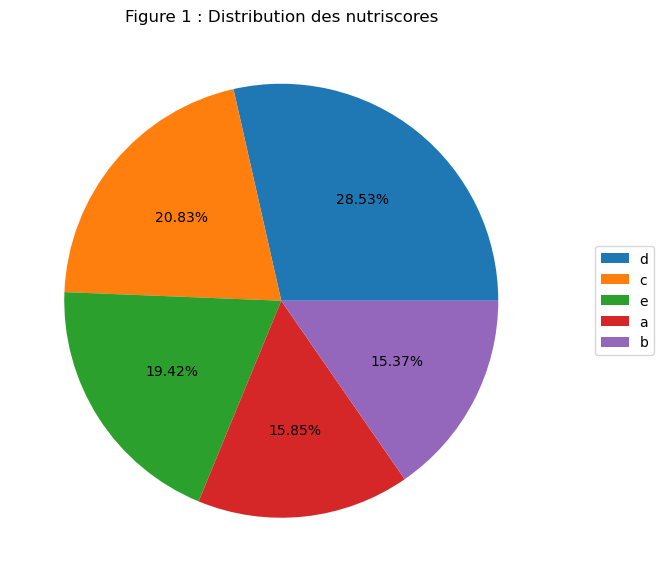

In [143]:
plt.figure()
work_df.nutrition_grade_fr.value_counts().plot.pie(legend=True, labels=None, figsize=(7,10), title='Figure 1 : Distribution des nutriscores', autopct='%1.2f%%')
plt.legend(work_df.nutrition_grade_fr.value_counts(dropna=True).index, loc=5, bbox_to_anchor=(1.20,0.5))
plt.ylabel('')
plt.savefig('figures/1_pie_nutriscore.png', bbox_inches="tight")
plt.show()

Il n'y pas de gros déséquilibre, les catégories C et E sont parfaitement équilibré.  
Cependant le score D est sureprésenté au détriment des scores A et B.

#### b) Catégorie

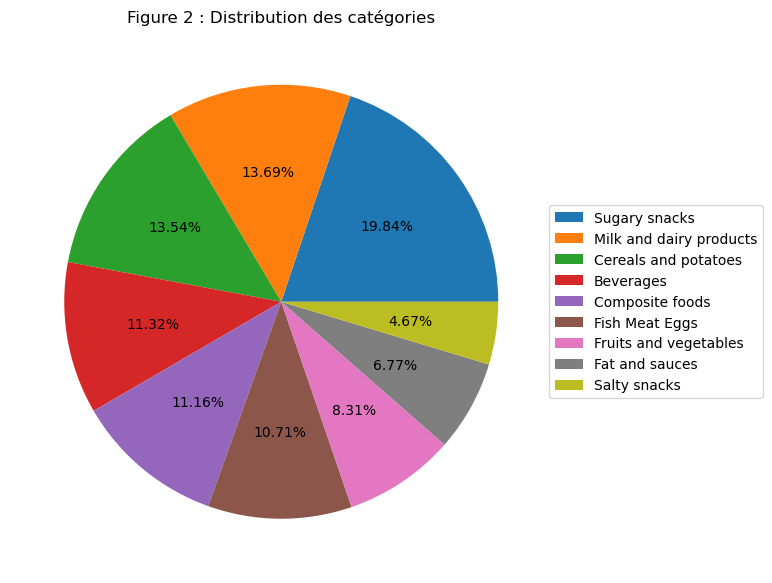

In [144]:
plt.figure()
work_df['category'].value_counts(dropna=True).plot.pie(labels=None, figsize=(7,10), autopct='%1.2f%%', title='Figure 2 : Distribution des catégories')
plt.legend(work_df['category'].value_counts(dropna=True).index, loc=5, bbox_to_anchor=(1.40,0.5))
plt.ylabel('')
plt.savefig('figures/2_pie_category.png', bbox_inches="tight")
plt.show()

On a également une distribution sans grand déséquilibre.  
On remarque tout de même que les snacks sucrés sont plus représentés et les snacks salés, les graisses et sauces et les fruits moins représentés.  
L'équilibre est cependant difficile à définir puisque qu'il faudrait avoir une distribution en accord avec nos besoin.  
En tout état de cause, les snacks ne me semble pas constitué un élément aussi important (20%) d'une bonne alimentation.

#### c) Pays

In [145]:
countries = work_df['countries_fr']
multiple_countries = countries[countries.str.contains(',', regex=False)]
countries.drop(multiple_countries.index, inplace=True)
for m in multiple_countries.tolist():
    countries.append(pd.Series(m.split()))

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2257255404.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  countries.append(pd.Series(m.split()))
C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2257255404.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  countries.append(pd.Series(m.split()))
C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2257255404.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  countries.append(pd.Series(m.split()))
C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2257255404.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  countries.append(pd.Series(m.split()))
C:\Users\USER\AppData\Local\Temp\ipykern

In [146]:
others = countries.value_counts().sum() - countries.value_counts()[:9].sum()
top_countries = countries.value_counts().head(9).append(pd.Series([others], index=["Autres"]))

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2495687566.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_countries = countries.value_counts().head(9).append(pd.Series([others], index=["Autres"]))


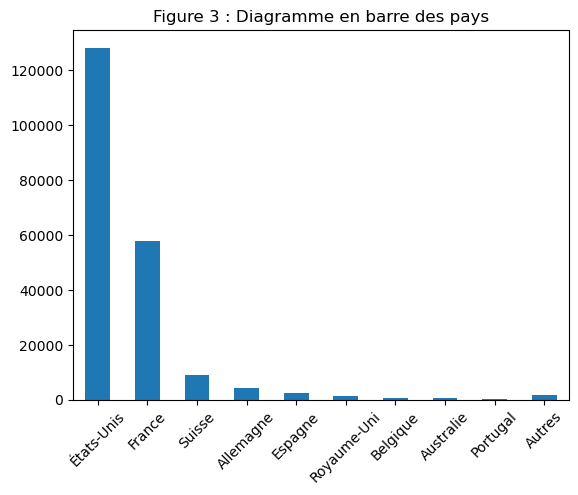

In [147]:
plt.figure()
top_countries.plot(kind='bar', title='Figure 3 : Diagramme en barre des pays')
plt.xticks(rotation=45)
plt.savefig('figures/3_barplot_countries.png', bbox_inches="tight")
plt.show()

Les produits sont majoritairement vendus aux Etats unis et en France avec quasi respectivement 2/3 et 1/3 des produits.

#### d) Marque

In [148]:
other_brands = work_df.brands.value_counts().sum() - work_df.brands.value_counts()[1:10].sum()
top_brands = work_df.brands.value_counts().head(10)[1:10].append(pd.Series([others], index=["Autres"]))

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\4256446998.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = work_df.brands.value_counts().head(10)[1:10].append(pd.Series([others], index=["Autres"]))


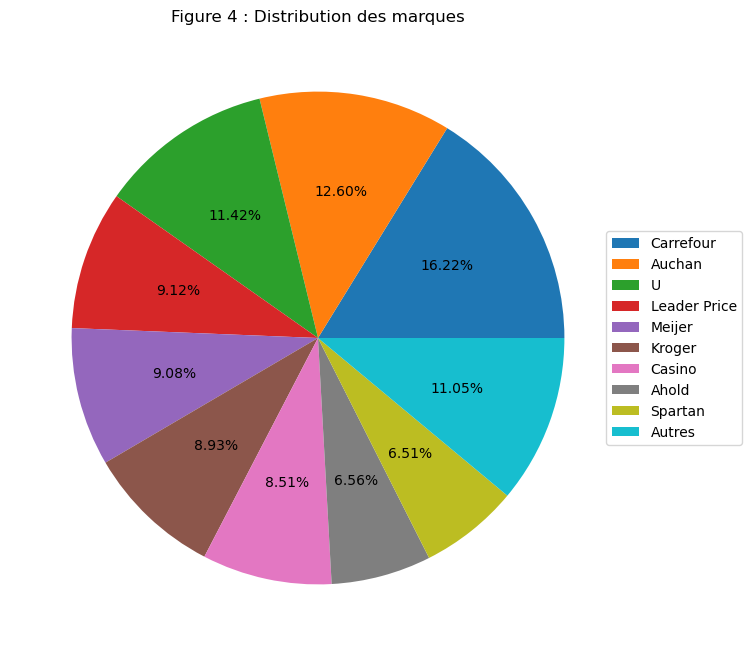

In [149]:
plt.figure()
top_brands.plot.pie(labels=None, figsize=(8,8), autopct='%1.2f%%', title='Figure 4 : Distribution des marques')
plt.legend(top_brands.index, loc=5, bbox_to_anchor=(1.20,0.5))
plt.ylabel('')
plt.savefig('figures/4_pie_brands.png', bbox_inches="tight")
plt.show()

On retrouve des franchises françaises et américaines en accord avec les pays de ventes.

### 2.5.2 Variables booléennes

#### a) Label

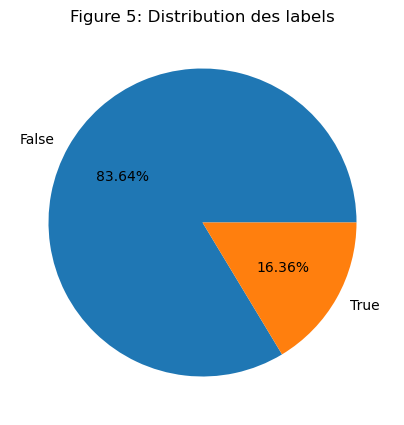

In [150]:
plt.figure()
work_df['labels_fr'].value_counts().plot.pie(figsize=(5,5), autopct='%1.2f%%', title="Figure 5: Distribution des labels")
plt.ylabel('')
plt.savefig('figures/5_pie_labels.png', bbox_inches="tight")
plt.show()

On a un peu plus de 16% des produits qui ont un label.

#### b) Huile de palme

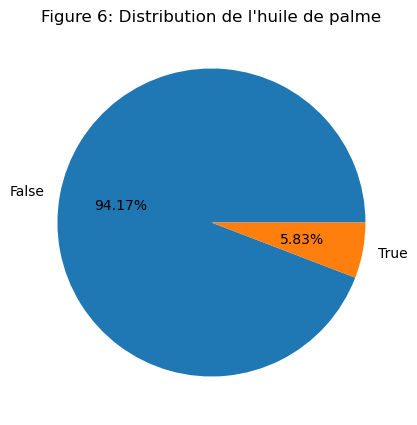

In [151]:
plt.figure()
work_df['palm_oil'].value_counts().plot.pie(figsize=(5,5), autopct='%1.2f%%', title="Figure 6: Distribution de l'huile de palme")
plt.ylabel('')
plt.savefig('figures/6_pie_palm_oil.png', bbox_inches="tight")
plt.show()

Environ 6% des produits peuvent contenir de l'huile de palme.

### 2.5.3 Variables quantitatives

#### a) Eléments nutritionnels

In [152]:
classic_elements = {
    'carbohydrates_100g',
    'fat_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'saturated_fat_100g',
    'sugars_100g',
}
particular_elements = {
    'trans_fat_100g',
    'calcium_100g'
    'cholesterol_100g',
    'iron_100g',
    'vitamin_a_100g',
    'vitamin_c_100g'
}

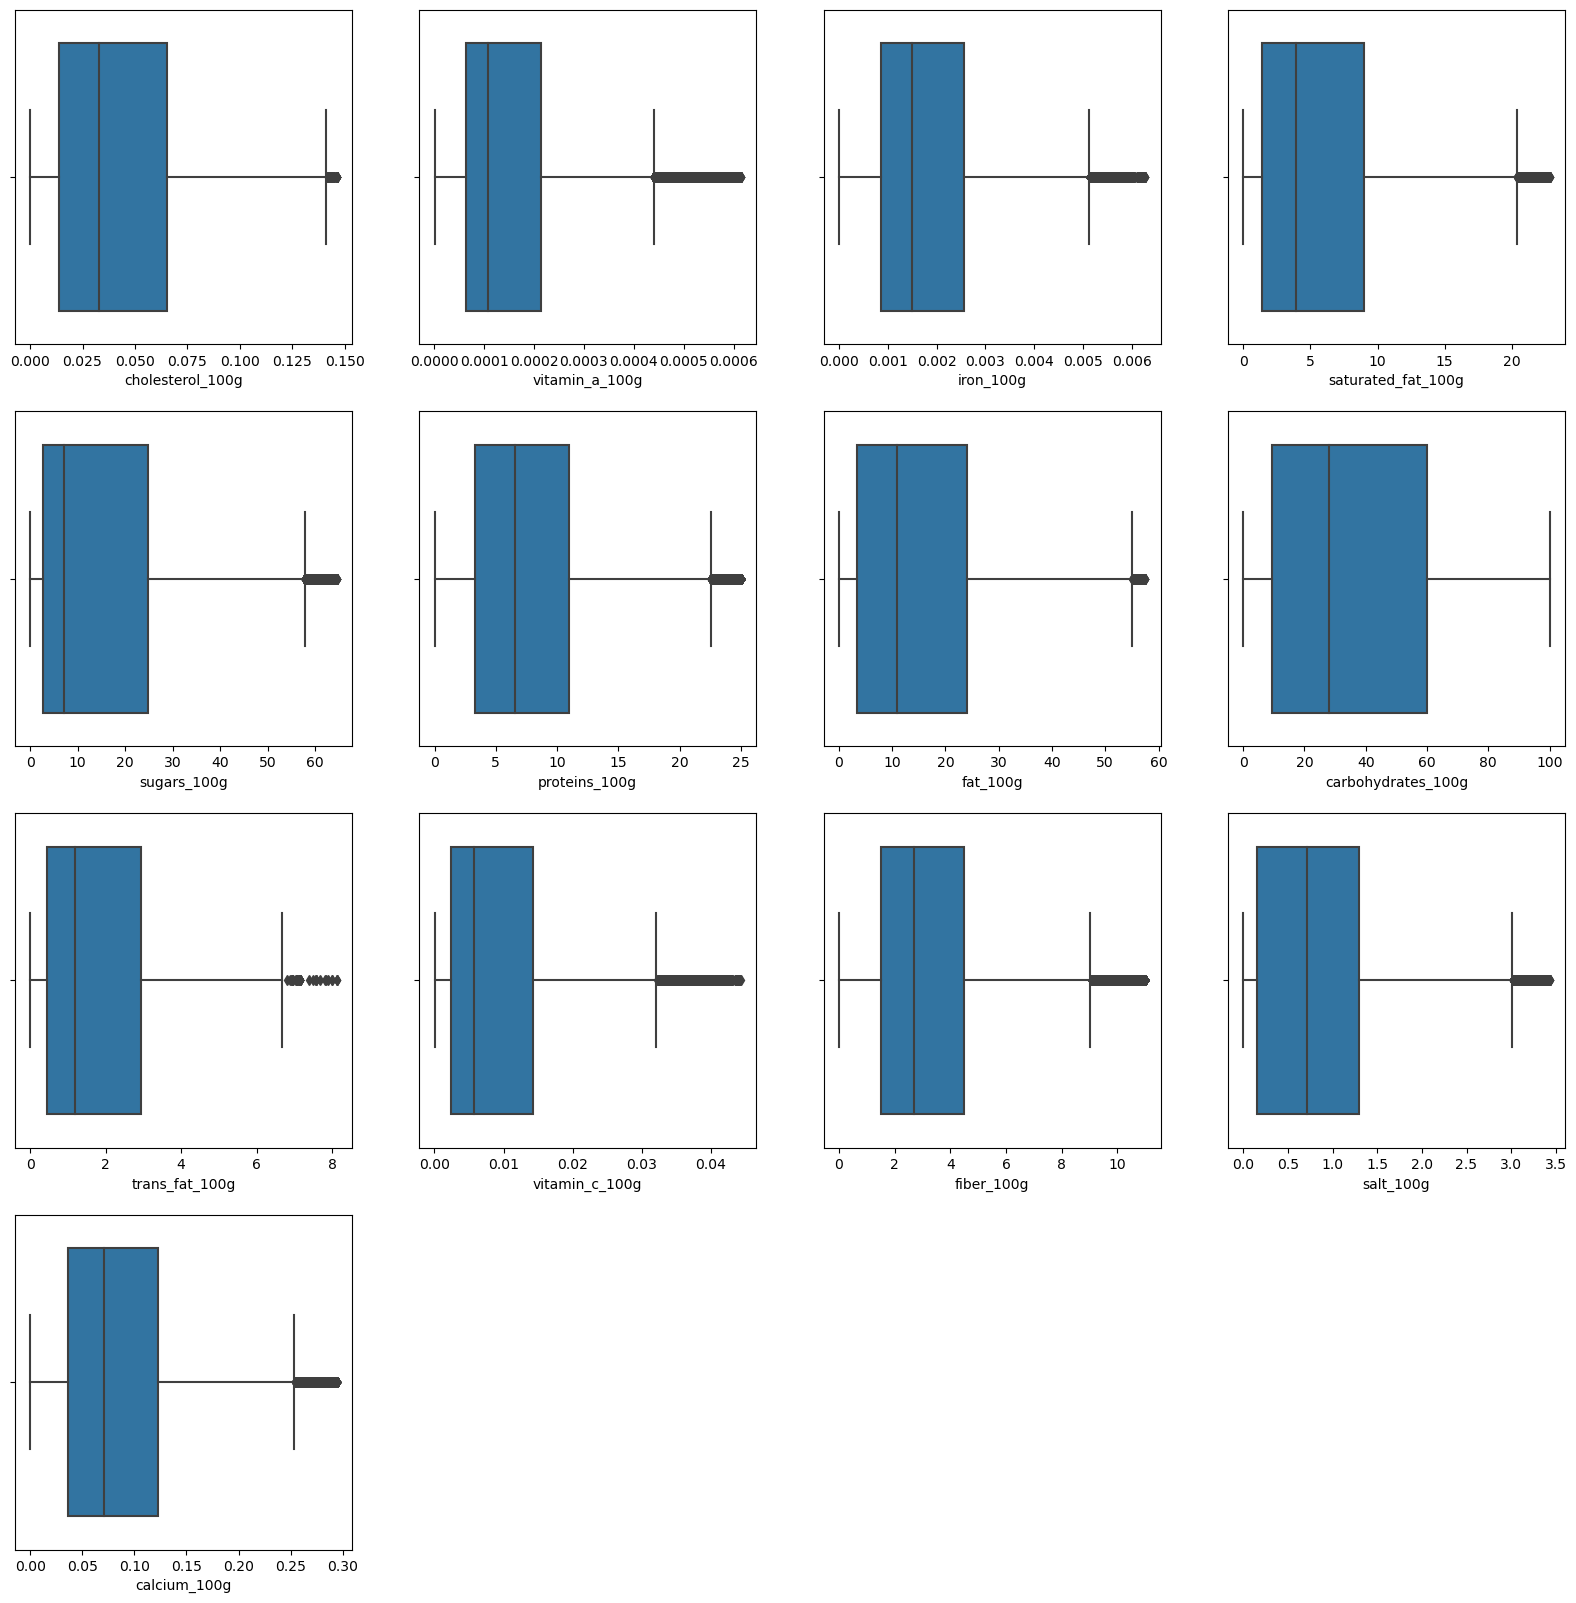

In [153]:
plt.figure(figsize=(20,20))
#plt.title("")
for count, element in enumerate(elements_columns):
    plt.subplot(4, 4, count+1)
    sns.boxplot(x=clean_na_outliersIQR_zeros(work_df[element]))
#plt.savefig("images/8_elements_boxplot.png")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\3828899466.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, count+1)


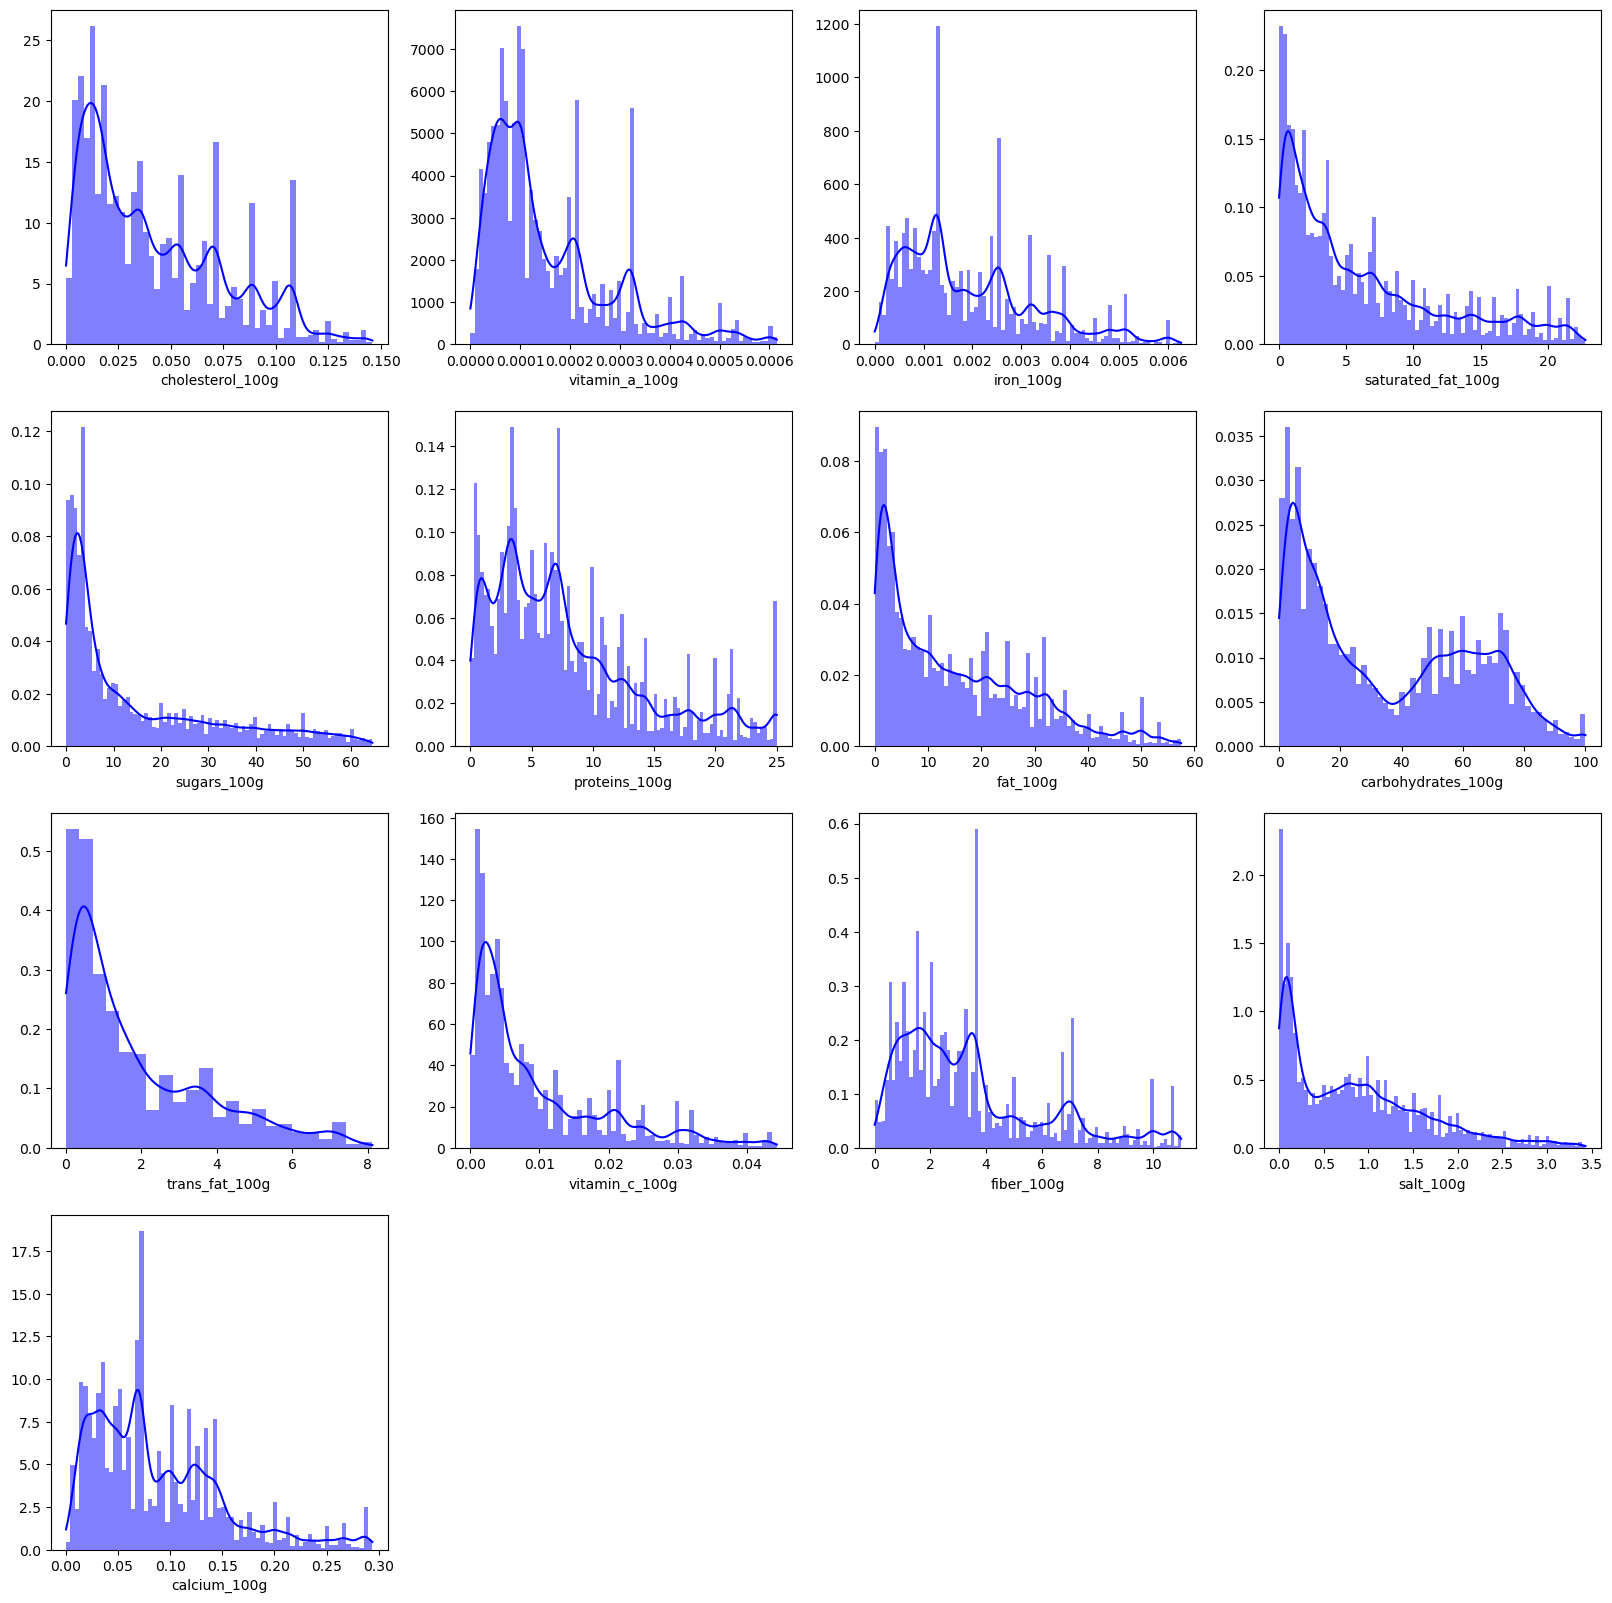

In [154]:
plt.figure(figsize=(20,20))
plt.title("Figure 7: Histogrammes des éléments nutritionnels")
for count, element in enumerate(elements_columns):
    plt.subplot(4, 4, count+1)
    sns.histplot(x=clean_na_outliersIQR_zeros(work_df[element]), color="blue", kde=True, stat="density", linewidth=0)
    plt.ylabel('')
plt.savefig("figures/7_elements_histplot.png")
plt.show()

In [155]:
french_elements = {
    'Glucides': 'carbohydrates_100g',
    'Graisses': 'fat_100g',
    'Fibres': 'fiber_100g',
    'Protéines': 'proteins_100g',
    'Sel': 'salt_100g',
    'Graisses saturées': 'saturated_fat_100g',
    'Sucre': 'sugars_100g',
}

@interact(element=french_elements)
def choix_element(element):
    sns.histplot(x=clean_na_outliersIQR_zeros(work_df[element]), color="blue", kde=True, stat="density", linewidth=0)

interactive(children=(Dropdown(description='element', options={'Glucides': 'carbohydrates_100g', 'Graisses': '…

On remarque que les quantités de vitamine C, d'acide gras trans ont une grande part de leur individus à 0.

#### b) L'énergie :

Il est difficile de définir des plafonds pour les valeurs aberrantes.
On utilise l'IQR pour comptabiliser leur nombre.

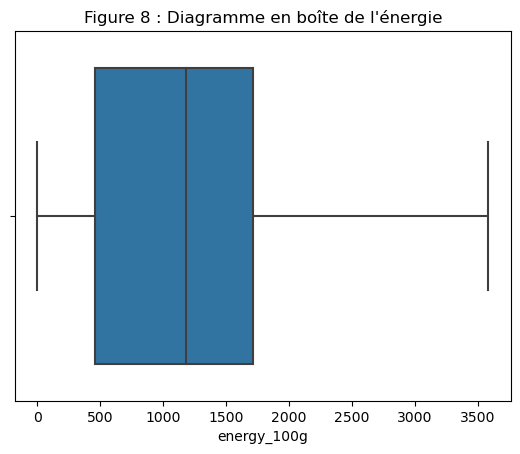

In [156]:
plt.figure()
plt.title("Figure 8 : Diagramme en boîte de l'énergie")
sns.boxplot(x=clean_na_outliersIQR(work_df['energy_100g']))
plt.savefig('figures/8_energy_boxplot.png')

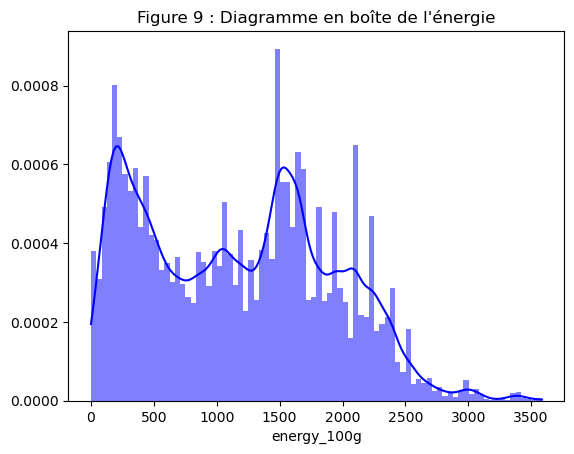

In [157]:
plt.figure()
plt.title("Figure 9 : Diagramme en boîte de l'énergie")
sns.histplot(x=clean_na_outliersIQR(work_df['energy_100g']), color="blue", kde=True, stat="density", linewidth=0)
plt.ylabel('')
plt.savefig('figures/9_energy_histplot.png')

#### c) Les additifs

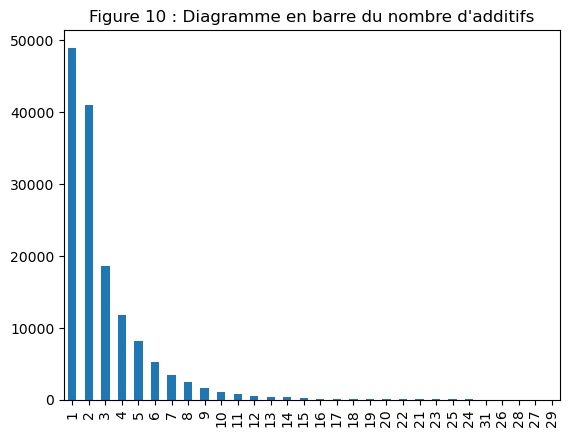

In [158]:
plt.figure()
plt.title("Figure 10 : Diagramme en barre du nombre d'additifs")
work_df[work_df['additives_n'] > 0]['additives_n'].value_counts().plot(kind='bar')
plt.savefig('figures/10_barplot_additives.png')

## 2.6. Analyse bivariée

### Méthodes

In [159]:
def boxplot_by_category(df, category_column, column):
    plt.figure()
    plt.title(column)
    
    groups = []
    categories = np.sort(df[category_column].unique())
    for c in categories:
        groups.append(df[df[category_column]==c][column])
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    plt.boxplot(groups, labels=categories, showfliers=False, medianprops=medianprops, 
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    

    

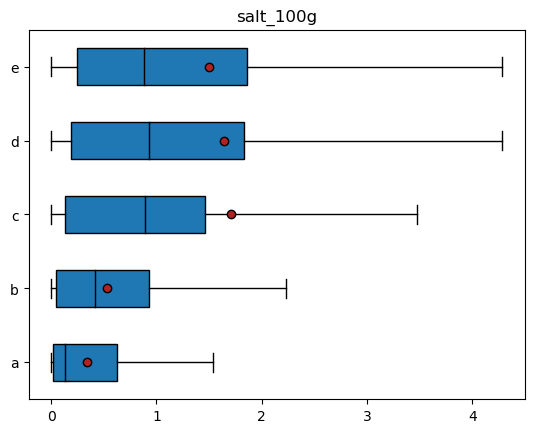

In [160]:
boxplot_by_category(work_df, "nutrition_grade_fr", 'salt_100g')

### Corrélations

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\592526930.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = work_df.corr()


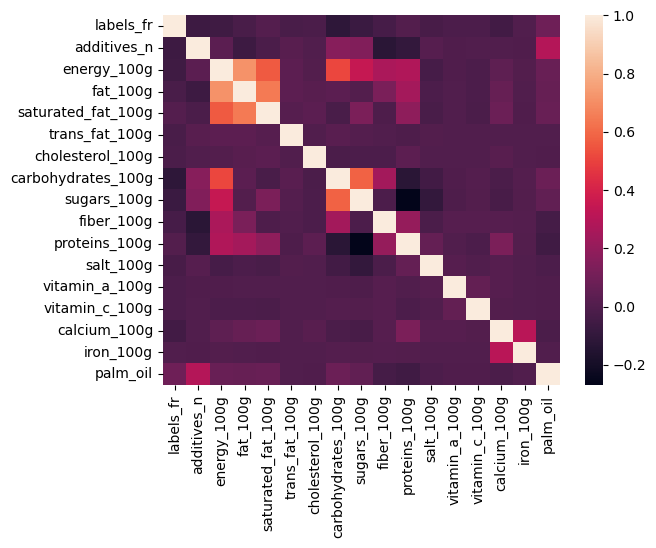

In [161]:
corr_df = work_df.corr()
sns.heatmap(corr_df)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\2480324449.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = work_df.corr()


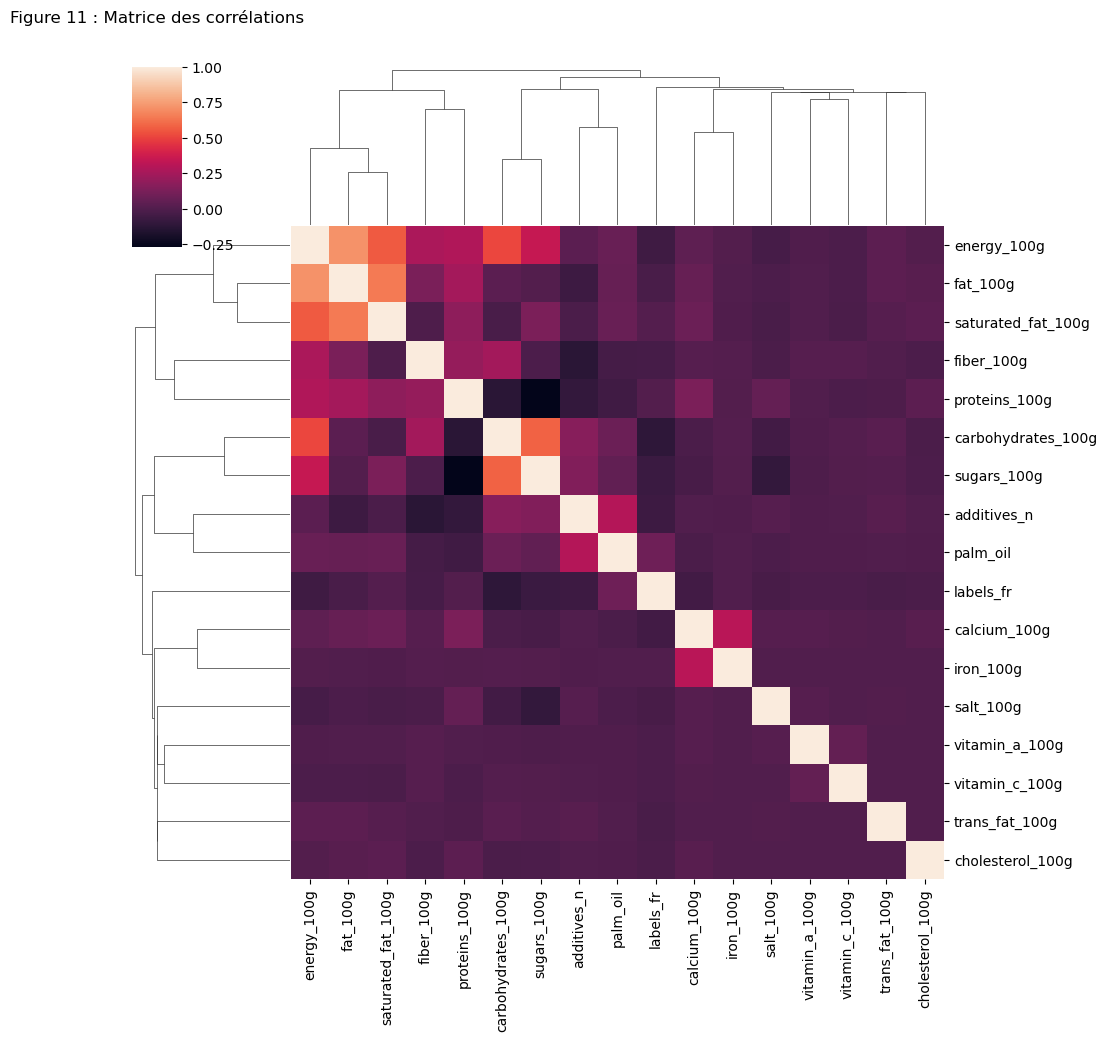

In [162]:
corr_df = work_df.corr()
sns.clustermap(corr_df)
plt.title("Figure 11 : Matrice des corrélations", loc='center', y=1.2)
plt.savefig('figures/11_correlations.png', bbox_inches="tight")
plt.show()


#### Sel et sodium

Cette corrélation est logique et n'apporte pas à notre analyse.

Le sodium a été retiré, pour exécuter cette ligne, commenter la ligne où il est retiré puis réexécuter les cellules.

In [163]:
# corr_df.salt_100g.sodium_100g

#### Sucres et glucides

Le sucre est un glucide, la corrélation semble logique.

In [164]:
corr_df.sugars_100g.carbohydrates_100g

0.5797448780086101

#### Energie, graisses, graisses saturées

In [165]:
print(corr_df.fat_100g.saturated_fat_100g)
print(corr_df.fat_100g.energy_100g)
print(corr_df.energy_100g.saturated_fat_100g)

0.6453485273557709
0.7163273369620816
0.5602454265813483


### Eléments avec nutriscore

In [ ]:
sns.pairplot(work_df[classic_elements.union({'nutrition_grade_fr'})], hue='nutrition_grade_fr', hue_order=['a','b','c','d','e'])
#plt.savefig('figures/pairplot.png', bbox_inches="tight")

C:\Users\USER\AppData\Local\Temp\ipykernel_8092\622417247.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sns.pairplot(work_df[classic_elements.union({'nutrition_grade_fr'})], hue='nutrition_grade_fr', hue_order=['a','b','c','d','e'])


In [ ]:
sorted_nutriscore = np.sort(work_df.nutrition_grade_fr.unique())

### ANOVA

Hypothèse nulle : les moyennes d'un élément sont égale pour chaque nutriscore.  
Hypothèse alternative : les moyennes sont différentes selon le nutriscore.

#### Exemple du sel :  

Détaillons la méthode pour l'un des éléments, pour bien comprendre le fonctionnement.  

On note :
 - n le nombre d'individus, soit le nombre de lignes de notre jeu de données : 209 289
 - I le nombre de modalités de nutriscore : 5


In [ ]:
n = work_df.shape[0]
I = work_df.nutrition_grade_fr.value_counts().shape[0]

On définit les moyennes :
- générale : $
y_{ . , . } = \frac{1}{n}
\sum_{i=1}^{I} { 
    \sum_{j=1}^{n_i} {
        y_{i,j}
    } 
}
$

- par nutriscore: $
y_{i,.} = \frac{1}{n_i} \sum_{i=1}^{n_i} {
    y_{i,j}
}
$

On va calculer les variations entre la moyenne générale et la moyenne pour un nutriscore.  
La variation interclasse : en français SCE (Somme des Carrés Expliqués), en anglais SSM (Sum of Squares of the Model).
\begin{equation}
SCE = \sum_{i=1}^{I} {n_i \times (y_{i,.} - y_{.,.})^2}
\end{equation}

On va calculer les variations à l'intérieur d'un nutriscore par rapport à la moyenne du nutriscore.  
Variation intraclasse : en français SCR (Somme des Carrés Résiduels), en anglais SSE (Sum of Squares of the Error).

\begin{equation}
SCR = \sum_{i=1}^{I} { 
    \sum_{j=1}^{n_i} {
        (y_{i,j} - y_{i,.})^2
    } 
}
\end{equation}

On divise ensuite par les degrés de liberté pour obtenir les Carrés Moyens :
\begin{equation}
   CME = \frac{SCE}{I-1}
\end{equation}

\begin{equation}
   CMR = \frac{SCR}{n-I}
\end{equation}

La statistique de test utilisée sera F:
\begin{equation}
   F = \frac{CME}{CMR}
\end{equation}

Cette statistique doit suivre une loi de Fisher à (I−1,n−I) degrés de liberté.  
Soit une loi de Fisher à (4, 209 284) degrés de liberté.

1. Calcul des n_i pour i dans la liste des nutriscore [a, b, c, d, e].

In [ ]:
n_a = work_df.nutrition_grade_fr.value_counts()["a"]
n_b = work_df.nutrition_grade_fr.value_counts()["b"]
n_c = work_df.nutrition_grade_fr.value_counts()["c"]
n_d = work_df.nutrition_grade_fr.value_counts()["d"]
n_e = work_df.nutrition_grade_fr.value_counts()["e"]

2. Calcul des moyennes pour l'élement sel par nutriscore (Que l'on a noté $y_{i,.}$)

In [ ]:
element = 'salt_100g'
mean_a = work_df[work_df.nutrition_grade_fr == "a"][element].mean()
mean_b = work_df[work_df.nutrition_grade_fr == "b"][element].mean()
mean_c = work_df[work_df.nutrition_grade_fr == "c"][element].mean()
mean_d = work_df[work_df.nutrition_grade_fr == "d"][element].mean()
mean_e = work_df[work_df.nutrition_grade_fr == "e"][element].mean()
mean_overall = work_df[element].mean()
print(
    f'Moyenne nutriscore A : {mean_a}',
    f'Moyenne nutriscore B : {mean_b}',
    f'Moyenne nutriscore C : {mean_c}',
    f'Moyenne nutriscore D : {mean_d}',
    f'Moyenne nutriscore E : {mean_e}',
    sep='\n')
print(50*'-')
print(f'Moyenne nutriscore : {mean_overall}')

On va clairement des différences, l'hypothèse devrait vraisemblablement être rejetée.

3. Calcul des variances :  
Dans le SCR, on peut voir apparaître la formule de la variance pour un nutriscore :
\begin{equation}
    \sum_{j=1}^{n_i} {
        (y_{i,j} - y_{i,.})^2
    }
\end{equation}
Observons donc les variances :

In [ ]:
var_a = work_df[work_df.nutrition_grade_fr == "a"][element].var()
var_b = work_df[work_df.nutrition_grade_fr == "b"][element].var()
var_c = work_df[work_df.nutrition_grade_fr == "c"][element].var()
var_d = work_df[work_df.nutrition_grade_fr == "d"][element].var()
var_e = work_df[work_df.nutrition_grade_fr == "e"][element].var()

print(
    f'Variance nutriscore A : {var_a}',
    f'Variance nutriscore B : {var_b}',
    f'Variance nutriscore C : {var_c}',
    f'Variance nutriscore D : {var_d}',
    f'Variance nutriscore E : {var_e}',
    sep='\n')

4. Calculs du SCE et du SCR :

In [ ]:
SCE = n_a * (mean_overall - mean_a)**2 + \
      n_b * (mean_overall - mean_b)**2 + \
      n_c * (mean_overall - mean_c)**2 + \
      n_d * (mean_overall - mean_d)**2 + \
      n_e * (mean_overall - mean_e)**2

print(f'SCE: {SCE}')

SCR = n_a * var_a + \
      n_b * var_b + \
      n_c * var_c + \
      n_d * var_d + \
      n_e * var_e
    
print(f'SCR: {SCR}')

5. Degrés de liberté

In [ ]:
ddl_SCE = I - 1
ddl_SCR = work_df.shape[0] - I 

6. Calculs des Carrés moyens

In [ ]:
CME = SCE/ddl_SCE
CMR = SCR/ddl_SCR

In [ ]:
print(CME, CMR)

7. Conclusion test statistiques

On calcul notre statistique F.

In [ ]:
f_stat = CME / CMR
print(f'F-Statistic: {f_stat}')

Il faut choisir un niveau de signification, on fixe 5%.
On calcule le quantile à 95% d'une loi de Fisher à (I−1, n−I) degrés de liberté.

In [ ]:

stats.f.ppf(0.95,dfn=ddl_SCE,dfd=ddl_SCR)

Pour valider l'hypothèse 0, il faut donc que notre statistique dépasse 2,37.  
En l'occurence, elle la dépasse largement : 1 051,60

#### Pour les autres éléments :
On utilise le package statsmodel pour accélérer les calculs.
On peut voir que les calculs pour le sel coïncident pratiquement**. 

**Le calcul du SCR (Résidual dans le tableau) est de 3.246990e+06 soit 3 246 990 au lieu de 3 247 059. Potentiellement des arrondis, l'effet est négligeable sur nos conclusions.

In [ ]:

for element in elements_columns:
    model = ols(str(element)+' ~ nutrition_grade_fr', data=work_df).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    print("-"*50)
    print(f'ANOVA for {element}')
    print(anova)

On retrouve dans l'ordre des valeurs de F :


| Element             | Statistique  F | Hypothèse|
| :------------------ | --------------:|:--------:|
| Graisses saturées   |    38 691.95   | Rejetée  |
| Graisses            |    19 465.13   | Rejetée  |        
| Sucre               |    13 298.32   | Rejetée  |
| Glucides            |     4 041.65   | Rejetée  |
| Fibres              |     2 961.08   | Rejetée  |
| Protéines           |     1 501.51   | Rejetée  |
| Sel                 |     1 051.62   | Rejetée  |
| Calcium             |       293.32   | Rejetée  |
| Graisses trans      |        73.66   | Rejetée  |
| Cholestérol         |        40.36   | Rejetée  |
| Vitamine C          |        18.57   | Rejetée  |
| Vitamine A          |         3.88   | Rejetée  |
| Fer                 |         1.85   | Validée  |

On voit logiquement que les éléments ont une influence notable sur le nutriscore, seul l'influence du fer est écarté par le test.  
On écarte également la vitamine A qui était proche d'être invalidée.

Seul les graisses et le sucre montrent des résultats probants avec l'ANOVA

In [ ]:
for element in classic_elements:
    df = clean_na_outliersIQR_zeros(work_df,[element])
    fig,axes=plt.subplots(1,2)
    fig.set_size_inches(15, 7)
    fig.suptitle(element, fontsize=16)
    ax1 = sns.boxplot(x='nutrition_grade_fr', y=element, data=df, order=sorted_nutriscore, ax=axes[0])
    ax1.set(xlabel='nutrition_grade_fr', ylabel='')
    ax2 = sns.kdeplot(data=df, x=element, hue="nutrition_grade_fr", hue_order=['a','b','c','d','e'], ax=axes[1])
    ax2.set(xlabel='quantity for 100g', ylabel='')
    plt.savefig(f'figures/nutriscore_{element}.png', bbox_inches="tight")
    plt.show()

#### Eléments par catégorie

## 2.7. Analyse multivariée

### ACP

In [ ]:
qualitative_columns = {
    'category', 'brands', 'countries_fr', 'labels_fr', 'palm_oil', 'nutrition_grade_fr'
}
pca_columns = work_df.drop(columns=qualitative_columns).columns
pca_columns

In [ ]:
df_pca = work_df[pca_columns]
df_pca

In [ ]:
n_comp = 6

In [ ]:
names = df_pca.index
features = df_pca.columns

In [ ]:
X = df_pca.values

In [ ]:
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [ ]:
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)

In [ ]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)

In [ ]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))



In [ ]:
# def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
#     for d1,d2 in axis_ranks:
#         if d2 < n_comp:
 
#             # initialisation de la figure       
#             fig = plt.figure(figsize=(7,6))
        
#             # affichage des points
#             if illustrative_var is None:
#                 plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
#             else:
#                 illustrative_var = np.array(illustrative_var)
#                 for value in np.unique(illustrative_var):
#                     selected = np.where(illustrative_var == value)
#                     plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
#                 plt.legend()

#             # affichage des labels des points
#             if labels is not None:
#                 for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
#                     plt.text(x, y, labels[i],
#                               fontsize='14', ha='center',va='center') 
                
#             # détermination des limites du graphique
#             boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
#             plt.xlim([-boundary,boundary])
#             plt.ylim([-boundary,boundary])
        
#             # affichage des lignes horizontales et verticales
#             plt.plot([-100, 100], [0, 0], color='grey', ls='--')
#             plt.plot([0, 0], [-100, 100], color='grey', ls='--')

#             # nom des axes, avec le pourcentage d'inertie expliqué
#             plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
#             plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

#             plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
#             plt.show(block=False)
# # Projection des individus
# X_projected = pca.transform(X_scaled)
# display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

# plt.show()